### Modis Download and Processing
Script designed to process Modis images and save them one by one.

1. Find vtiles/htiles/dates for each data point
2. define windows around them, cut image
3. save images 

Potentially intended to offload eventually to azure vms

__________________________
Currently only compiled for train labels

In [1]:
import pandas as pd
import geojson as gsn
from pyproj import Proj
from osgeo import gdal
from osgeo import gdalconst

import tempfile
import wget
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import os
import pickle
from collections import defaultdict
from datetime import datetime, timedelta

import xarray as xr
import rioxarray as rxr
from azure.storage.blob import ContainerClient

modis_account_name = 'modissa'
modis_container_name = 'modis-006'
modis_account_url = 'https://' + modis_account_name + '.blob.core.windows.net/'
modis_blob_root = modis_account_url + modis_container_name + '/'

# This file is provided by NASA; it indicates the lat/lon extents of each
# NOTE: this was from tutorial, not actually helpful because unprojected?

modis_tile_extents_url = modis_blob_root + 'sn_bound_10deg.txt'

temp_dir = os.path.join(tempfile.gettempdir(),'modis_snow')
os.makedirs(temp_dir,exist_ok=True)
fn = os.path.join(temp_dir,modis_tile_extents_url.split('/')[-1])
# wget.download(modis_tile_extents_url, fn)


modis_container_client = ContainerClient(account_url=modis_account_url, 
                                         container_name=modis_container_name,
                                                  credential=None)

#### Modis/azure helpers


In [2]:
def lat_lon_to_modis_tile(lat,lon):
    '''converts lat lon to modis tiles but reconstructing grid and its projection'''
    
    CELLS = 2400
    VERTICAL_TILES = 18
    HORIZONTAL_TILES = 36
    EARTH_RADIUS = 6371007.181
    EARTH_WIDTH = 2 * math.pi * EARTH_RADIUS

    TILE_WIDTH = EARTH_WIDTH / HORIZONTAL_TILES
    TILE_HEIGHT = TILE_WIDTH
    CELL_SIZE = TILE_WIDTH / CELLS
    
    MODIS_GRID = Proj(f'+proj=sinu +R={EARTH_RADIUS} +nadgrids=@null +wktext')
    
    x, y = MODIS_GRID(lon, lat)
    h = (EARTH_WIDTH * .5 + x) / TILE_WIDTH
    v = -(EARTH_WIDTH * .25 + y - (VERTICAL_TILES - 0) * TILE_HEIGHT) / TILE_HEIGHT
    
    return int(h), int(v)


def list_blobs_in_folder(container_name,folder_name):
    """
    List all blobs in a virtual folder in an Azure blob container
    """
    
    files = []
    generator = modis_container_client.list_blobs(name_starts_with=folder_name)
    for blob in generator:
        files.append(blob.name)
    return files
        
    
def list_hdf_blobs_in_folder(container_name,folder_name):
    """"
    List .hdf files in a folder
    """
    
    files = list_blobs_in_folder(container_name,folder_name)
    files = [fn for fn in files if fn.endswith('.hdf')]
    return files

# daynum = '2014236'
def daynum_gen(date_time):
    '''converts date time objects to filename'''
    doy = date_time.timetuple().tm_yday
    year = date_time.year
    return str(year) + '{:03d}'.format(doy)

In [35]:
def images_downloader(tiles, centroids, out_dataset, prod_name, verbose = False):
    """"""
    cell_ids = []
    i = 0
    for date_tile in tqdm(tiles.keys()):
        print("\n",i)

        date = date_tile[0]
        daynum = daynum_gen(date)
        daynum_og = daynum #to save later
        tile_num = (date_tile[1],date_tile[2])

        folder = prod_name + '/' + '{:0>2d}/{:0>2d}'.format(date_tile[1],date_tile[2]) + '/' + daynum


        # Find all HDF files from this tile on this day
        filenames = list_hdf_blobs_in_folder(modis_container_name,folder)
        print('Found {} matching file(s):'.format(len(filenames)))
        for fn in filenames:
            print(fn)
        file_root = filenames.copy()
        
        if len(file_root) > 1: #images may come in multiples
            print("multiple files found: ", len(file_root))
            blob_name1 = filenames[0]
            blob_name2 = filenames[1]
            
            # Download to a temporary file
            url1 = modis_blob_root + blob_name1
            url2 = modis_blob_root + blob_name2

            filename = os.path.join(temp_dir,blob_name1.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url1,filename)
                
            filename = os.path.join(temp_dir,blob_name2.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url2,filename)
            rds1 = rxr.open_rasterio(filename)
            rds2 = rxr.open_rasterio(filename)
            
            #find highest quality image
            rds1_quality = ((rds1.NDSI_Snow_Cover_Basic_QA.values >0) | (rds1.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            rds2_quality = ((rds2.NDSI_Snow_Cover_Basic_QA.values >0) | (rds2.NDSI_Snow_Cover_Basic_QA.values < 2)).sum()
            
            rds = rds1 if rds1_quality >= rds2_quality else rds2 
                
        else:
            # Work with the first returned URL
            file_found = False
            breaker = 1
            while not file_found and breaker <= 5:
                try:
                    blob_name = filenames[0]
                    file_found = True
                except IndexError:
                    print("No file found: tile {} date {}".format(tile_num,daynum))
                    date -= timedelta(days=1)
                    daynum = daynum_gen(date) 

                    breaker +=1 
                    print("trying:", daynum)
            if breaker == 5:
                raise ValueError("Image", tile_num, daynum, "not found")


            # Download to a temporary file
            url = modis_blob_root + blob_name
            filename = os.path.join(temp_dir,blob_name.replace('/','_'))
            if not os.path.isfile(filename):
                wget.download(url,filename)

            rds = rxr.open_rasterio(filename)

        #####reproject#####
        image = rds.rio.reproject(dst_crs="EPSG:4326")

#         #rewrite missing values for saving
#         image = image.where(image != 255, other = 32767) 

        for var in image.data_vars:
            image[var]=image[var].astype(image[var].dtype,keep_attrs = False) 

        #####create blocks around centroids#####    
        cells = tiles[date_tile]
        for cell in cells:
            center = centroids[cell]


            x_idx = np.nanargmin(np.abs(image.x.values - center[0]))
            y_idx = np.nanargmin(np.abs(image.y.values - center[1]))

            #subset 21x21 square
            xmin, xmin_actual, xmax = max(x_idx -10, 0) , x_idx -10, x_idx + 11 
            ymin, ymin_actual, ymax = max(y_idx -10, 0) , y_idx -10, y_idx + 11

            sub_image = image[dict(x= slice(xmin,xmax), y= slice(ymin,ymax))]

            try: # in case we're against boundary
                sub_image = sub_image.squeeze().to_array().to_numpy()
                out_dataset[i] = sub_image
            except ValueError as e:                
                #flip and reflip before saving because coding's hard
                sub_image = np.swapaxes(sub_image, 1,2)
                
                image_shape = tuple(image.dims[d] for d in ['x', 'y'])
                simage_shape = sub_image.shape
                if verbose:
                    print(e)
                    print("Out of bounds error, padding with 0 for day/grid:", daynum_og, cell)

                    print("input shape: ", image_shape, "output shape", simage_shape)
                    print("max/min", xmax, ymax, xmin, ymin)
                    
                    return image
                #pad with necessary columns
                if xmin_actual < 0:                    
                    fill = np.zeros((out_dataset.shape[1],
                                     0-xmin_actual, simage_shape[1]))
                    sub_image = np.concatenate((fill, sub_image), axis= 1)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off left")
                        print("updated simage_shape", simage_shape)
                    
                elif xmax > image_shape[0]:
                    fill = np.zeros((out_dataset.shape[1],
                                    xmax- image_shape[0], simage_shape[1]))
                    sub_image = np.concatenate((sub_image, fill), axis=1)
                    simage_shape = sub_image.shape
                    print("off right")
                    print("updated simage_shape", simage_shape)
                
                if ymin_actual < 0 :
                    fill = np.zeros((out_dataset.shape[1],
                                   21, 0-ymin_actual ))
                    sub_image = np.concatenate((fill, sub_image), axis=2)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off up")
                        print("updated simage_shape", simage_shape)

                elif ymax > image_shape[1]:
                    fill = np.zeros((out_dataset.shape[1],
                                     21, ymax - image_shape[1] ))
                    sub_image = np.concatenate((sub_image,fill), axis=2)
                    simage_shape = sub_image.shape
                    if verbose:
                        print("off down")
                        print("updated simage_shape", simage_shape)
                    
                sub_image = np.swapaxes(sub_image, 1,2)
                out_dataset[i] = sub_image
                
#                 print("Center:", center , "max x", image.x.max().values, "min x", image.x.min().values,
#                  "max y", image.y.max().values, "min y", image.y.min().values)
                
                
            cell_ids.append((cell, daynum_og)) 

            i+=1
        
        
        
    return cell_ids, out_dataset


Ingest training + testing geodata and timestamps

Note: paths are currently absolute, but happy to make them work on both machines

In [4]:
path = "C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/grid_cells.geojson"
with open(path) as f:
    gj = gsn.load(f)
print(len(gj['features']))

18130


Estimate centroids for lat_lon calculations by taking mean of points (not actual centroid because of projection and great circle distance?)

In [5]:
centroids = {} #cellid : centroid

for cell in range(len(gj['features'])):
    assert len(gj['features'][cell]['geometry']['coordinates'][0]) == 5 #coordinates have repeat on fifth, make sure this is universal
    
    cell_id =gj['features'][cell]['properties']['cell_id']
    centroid = list(np.mean(
        gj['features'][cell]['geometry']['coordinates'][0][0:4],
        axis = 0)) #lazy centroid calculation
    centroids[cell_id] = centroid

1. Ingest training, testing, submission datasets
2. Find what tiles (time, h,v) each image are stored in
3. store by cell_id, recall later for centroids

In [6]:
train_feat = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_train_features.csv")
test =pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_test_features.csv")
submission = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/submission_format.csv")
train_y = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/train_labels.csv") 
metadata = pd.read_csv("C:/Users/Matt/Documents/Python Scripts/SnowComp/dat/ground_measures_metadata.csv")

## Download relevant images

Process and save smaller images one by one

### Train labels

In [7]:
#grab date/cell_id combos
dates = {}

#go through all rows, grab nonnull dates
for i in range(train_y.shape[0]):
    dates[train_y.iloc[i,0]] =list(
        train_y.iloc[i,1:][~train_y.iloc[i,:].isnull()].index)#cell_id : [dates]


Compile overlapping tiles

In [13]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in tqdm(dates.items()):
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

  0%|          | 0/10878 [00:00<?, ?it/s]

total squares: 91490


Load Terra images

In [14]:
product = 'MOD10A1' # Terra -morning
# product = 'MCD43A4'

#initialize empty array
dataset_t = np.empty((counter, 7, 21, 21)) #(image, band, row, column)
    
# download dataset
cell_ids, dataset_t = images_downloader(tiles, centroids, dataset_t, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImagesT.npy"
np.save(output_path,dataset_t)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

  0%|          | 0/1120 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MOD10A1/08/05/2018116/MOD10A1.A2018116.h08v05.006.2018118031402.hdf

 1468
Found 1 matching file(s):
MOD10A1/08/05/2019075/MOD10A1.A2019075.h08v05.006.2019077031831.hdf

 2937
Found 1 matching file(s):
MOD10A1/08/05/2019108/MOD10A1.A2019108.h08v05.006.2019110033147.hdf

 4406
Found 1 matching file(s):
MOD10A1/08/05/2019118/MOD10A1.A2019118.h08v05.006.2019120033847.hdf

 5875
Found 1 matching file(s):
MOD10A1/08/05/2019159/MOD10A1.A2019159.h08v05.006.2019161025247.hdf

 6740
Found 1 matching file(s):
MOD10A1/09/05/2016094/MOD10A1.A2016094.h09v05.006.2016104070530.hdf

 7910
Found 1 matching file(s):
MOD10A1/08/05/2018063/MOD10A1.A2018063.h08v05.006.2018065091856.hdf

 8503
Found 1 matching file(s):
MOD10A1/08/05/2018112/MOD10A1.A2018112.h08v05.006.2018114031316.hdf

 9110
Found 1 matching file(s):
MOD10A1/08/05/2018152/MOD10A1.A2018152.h08v05.006.2018154033710.hdf

 10111
Found 1 matching file(s):
MOD10A1/08/05/2019074/MOD10A1.A2019074.h08v05.006.2019076031


 33437
Found 1 matching file(s):
MOD10A1/08/04/2014119/MOD10A1.A2014119.h08v04.006.2016170141445.hdf

 33443
Found 1 matching file(s):
MOD10A1/08/04/2014126/MOD10A1.A2014126.h08v04.006.2016170144515.hdf

 33449
Found 1 matching file(s):
MOD10A1/08/04/2014133/MOD10A1.A2014133.h08v04.006.2016170160349.hdf

 33455
Found 1 matching file(s):
MOD10A1/08/04/2014140/MOD10A1.A2014140.h08v04.006.2016170044759.hdf

 33461
Found 1 matching file(s):
MOD10A1/08/04/2014147/MOD10A1.A2014147.h08v04.006.2016170050145.hdf

 33467
Found 1 matching file(s):
MOD10A1/08/04/2014154/MOD10A1.A2014154.h08v04.006.2016170033117.hdf

 33473
Found 1 matching file(s):
MOD10A1/08/04/2014161/MOD10A1.A2014161.h08v04.006.2016170071247.hdf

 33479
Found 1 matching file(s):
MOD10A1/08/04/2014168/MOD10A1.A2014168.h08v04.006.2016170213654.hdf

 33485
Found 1 matching file(s):
MOD10A1/08/04/2014175/MOD10A1.A2014175.h08v04.006.2016170192519.hdf

 33491
Found 1 matching file(s):
MOD10A1/08/04/2014336/MOD10A1.A2014336.h08v04.00


 33943
Found 1 matching file(s):
MOD10A1/08/04/2017094/MOD10A1.A2017094.h08v04.006.2017096053335.hdf

 33949
Found 1 matching file(s):
MOD10A1/08/04/2017101/MOD10A1.A2017101.h08v04.006.2017103033744.hdf

 33956
Found 1 matching file(s):
MOD10A1/08/04/2017108/MOD10A1.A2017108.h08v04.006.2017110030801.hdf

 33963
Found 1 matching file(s):
MOD10A1/08/04/2017115/MOD10A1.A2017115.h08v04.006.2017117025933.hdf

 33970
Found 1 matching file(s):
MOD10A1/08/04/2017122/MOD10A1.A2017122.h08v04.006.2017124031701.hdf

 33977
Found 1 matching file(s):
MOD10A1/08/04/2017129/MOD10A1.A2017129.h08v04.006.2017137214927.hdf

 33983
Found 1 matching file(s):
MOD10A1/08/04/2017136/MOD10A1.A2017136.h08v04.006.2017138030804.hdf

 33989
Found 1 matching file(s):
MOD10A1/08/04/2017143/MOD10A1.A2017143.h08v04.006.2017145031639.hdf

 33994
Found 1 matching file(s):
MOD10A1/08/04/2017150/MOD10A1.A2017150.h08v04.006.2017152031055.hdf

 33999
Found 1 matching file(s):
MOD10A1/08/04/2017157/MOD10A1.A2017157.h08v04.00


 36559
Found 1 matching file(s):
MOD10A1/08/05/2016117/MOD10A1.A2016117.h08v05.006.2016119065405.hdf

 37292
Found 1 matching file(s):
MOD10A1/08/05/2016130/MOD10A1.A2016130.h08v05.006.2016132074011.hdf

 38019
Found 1 matching file(s):
MOD10A1/08/05/2017029/MOD10A1.A2017029.h08v05.006.2017032012323.hdf

 38726
Found 1 matching file(s):
MOD10A1/08/05/2018148/MOD10A1.A2018148.h08v05.006.2018150042246.hdf

 39433
Found 1 matching file(s):
MOD10A1/08/05/2019107/MOD10A1.A2019107.h08v05.006.2019109032744.hdf

 40424
Found 1 matching file(s):
MOD10A1/08/05/2019123/MOD10A1.A2019123.h08v05.006.2019125234149.hdf

 41133
Found 1 matching file(s):
MOD10A1/08/05/2019164/MOD10A1.A2019164.h08v05.006.2019166033705.hdf

 41842
Found 1 matching file(s):
MOD10A1/09/05/2018089/MOD10A1.A2018089.h09v05.006.2018093185834.hdf

 42223
Found 1 matching file(s):
MOD10A1/09/05/2019098/MOD10A1.A2019098.h09v05.006.2019100033234.hdf

 42522
Found 1 matching file(s):
MOD10A1/09/05/2019160/MOD10A1.A2019160.h09v05.00


 48764
Found 1 matching file(s):
MOD10A1/08/05/2015020/MOD10A1.A2015020.h08v05.006.2016173060803.hdf

 48795
Found 1 matching file(s):
MOD10A1/08/05/2015027/MOD10A1.A2015027.h08v05.006.2016173060920.hdf

 48826
Found 1 matching file(s):
MOD10A1/08/05/2015034/MOD10A1.A2015034.h08v05.006.2016173061014.hdf

 48857
Found 1 matching file(s):
MOD10A1/08/05/2015041/MOD10A1.A2015041.h08v05.006.2016173061131.hdf

 48888
Found 1 matching file(s):
MOD10A1/08/05/2015048/MOD10A1.A2015048.h08v05.006.2016173234839.hdf

 48919
Found 1 matching file(s):
MOD10A1/08/05/2015055/MOD10A1.A2015055.h08v05.006.2016174011608.hdf

 48950
Found 1 matching file(s):
MOD10A1/08/05/2015062/MOD10A1.A2015062.h08v05.006.2016173234221.hdf

 48980
Found 1 matching file(s):
MOD10A1/08/05/2015069/MOD10A1.A2015069.h08v05.006.2016173140448.hdf

 49011
Found 1 matching file(s):
MOD10A1/08/05/2015076/MOD10A1.A2015076.h08v05.006.2016173140325.hdf

 49042
Found 1 matching file(s):
MOD10A1/08/05/2015083/MOD10A1.A2015083.h08v05.00


 51107
Found 1 matching file(s):
MOD10A1/08/05/2017150/MOD10A1.A2017150.h08v05.006.2017152032856.hdf

 51135
Found 1 matching file(s):
MOD10A1/08/05/2017157/MOD10A1.A2017157.h08v05.006.2017159034556.hdf

 51163
Found 1 matching file(s):
MOD10A1/08/05/2017164/MOD10A1.A2017164.h08v05.006.2017166030123.hdf

 51191
Found 1 matching file(s):
MOD10A1/08/05/2017171/MOD10A1.A2017171.h08v05.006.2017173030919.hdf

 51218
Found 1 matching file(s):
MOD10A1/08/05/2017339/MOD10A1.A2017339.h08v05.006.2017341031007.hdf

 51247
Found 1 matching file(s):
MOD10A1/08/05/2017346/MOD10A1.A2017346.h08v05.006.2017348031129.hdf

 51276
Found 1 matching file(s):
MOD10A1/08/05/2017353/MOD10A1.A2017353.h08v05.006.2017355030231.hdf

 51305
Found 1 matching file(s):
MOD10A1/08/05/2017360/MOD10A1.A2017360.h08v05.006.2017362032454.hdf

 51334
Found 1 matching file(s):
MOD10A1/08/05/2018002/MOD10A1.A2018002.h08v05.006.2018004030713.hdf

 51363
Found 1 matching file(s):
MOD10A1/08/05/2018009/MOD10A1.A2018009.h08v05.00


 54025
Found 1 matching file(s):
MOD10A1/10/04/2013085/MOD10A1.A2013085.h10v04.006.2016139195613.hdf

 54074
Found 1 matching file(s):
MOD10A1/10/04/2013092/MOD10A1.A2013092.h10v04.006.2016139044617.hdf

 54123
Found 1 matching file(s):
MOD10A1/10/04/2013099/MOD10A1.A2013099.h10v04.006.2016139213038.hdf

 54172
Found 1 matching file(s):
MOD10A1/10/04/2013106/MOD10A1.A2013106.h10v04.006.2016139005006.hdf

 54221
Found 1 matching file(s):
MOD10A1/10/04/2013113/MOD10A1.A2013113.h10v04.006.2016139010155.hdf

 54270
Found 1 matching file(s):
MOD10A1/10/04/2013120/MOD10A1.A2013120.h10v04.006.2016140060719.hdf

 54319
Found 1 matching file(s):
MOD10A1/10/04/2013127/MOD10A1.A2013127.h10v04.006.2016140060751.hdf

 54368
Found 1 matching file(s):
MOD10A1/10/04/2013134/MOD10A1.A2013134.h10v04.006.2016142050711.hdf

 54417
Found 1 matching file(s):
MOD10A1/10/04/2013141/MOD10A1.A2013141.h10v04.006.2016142055456.hdf

 54466
Found 1 matching file(s):
MOD10A1/10/04/2013148/MOD10A1.A2013148.h10v04.00


 57994
Found 1 matching file(s):
MOD10A1/10/04/2016012/MOD10A1.A2016012.h10v04.006.2016182220242.hdf

 58043
Found 1 matching file(s):
MOD10A1/10/04/2016019/MOD10A1.A2016019.h10v04.006.2016021065536.hdf

 58092
Found 1 matching file(s):
MOD10A1/10/04/2016026/MOD10A1.A2016026.h10v04.006.2016028091537.hdf

 58141
Found 1 matching file(s):
MOD10A1/10/04/2016033/MOD10A1.A2016033.h10v04.006.2016036011953.hdf

 58190
Found 1 matching file(s):
MOD10A1/10/04/2016040/MOD10A1.A2016040.h10v04.006.2016042071912.hdf

 58239
Found 1 matching file(s):
MOD10A1/10/04/2016047/MOD10A1.A2016047.h10v04.006.2016049071539.hdf

 58288
Found 0 matching file(s):
No file found: tile (10, 4) date 2016054
trying: 2016053
No file found: tile (10, 4) date 2016053
trying: 2016052
No file found: tile (10, 4) date 2016052
trying: 2016051
No file found: tile (10, 4) date 2016051
trying: 2016050
No file found: tile (10, 4) date 2016050
trying: 2016049

 58337
Found 1 matching file(s):
MOD10A1/10/04/2016061/MOD10A1.A2016


 61840
Found 1 matching file(s):
MOD10A1/10/04/2018142/MOD10A1.A2018142.h10v04.006.2018144033522.hdf

 61888
Found 1 matching file(s):
MOD10A1/10/04/2018149/MOD10A1.A2018149.h10v04.006.2018151040520.hdf

 61936
Found 1 matching file(s):
MOD10A1/10/04/2018156/MOD10A1.A2018156.h10v04.006.2018158035030.hdf

 61984
Found 1 matching file(s):
MOD10A1/10/04/2018163/MOD10A1.A2018163.h10v04.006.2018166205104.hdf

 62032
Found 1 matching file(s):
MOD10A1/10/04/2018170/MOD10A1.A2018170.h10v04.006.2018172032026.hdf

 62080
Found 1 matching file(s):
MOD10A1/10/04/2018177/MOD10A1.A2018177.h10v04.006.2018179032850.hdf

 62128
Found 1 matching file(s):
MOD10A1/10/04/2018338/MOD10A1.A2018338.h10v04.006.2018340034328.hdf

 62177
Found 1 matching file(s):
MOD10A1/10/04/2018345/MOD10A1.A2018345.h10v04.006.2018347025910.hdf

 62226
Found 1 matching file(s):
MOD10A1/10/04/2018352/MOD10A1.A2018352.h10v04.006.2018354025820.hdf

 62275
Found 1 matching file(s):
MOD10A1/10/04/2018359/MOD10A1.A2018359.h10v04.00


 67363
Found 1 matching file(s):
MOD10A1/09/04/2014070/MOD10A1.A2014070.h09v04.006.2016169075628.hdf

 67451
Found 1 matching file(s):
MOD10A1/09/04/2014077/MOD10A1.A2014077.h09v04.006.2016169073520.hdf

 67539
Found 1 matching file(s):
MOD10A1/09/04/2014084/MOD10A1.A2014084.h09v04.006.2016169045231.hdf

 67627
Found 1 matching file(s):
MOD10A1/09/04/2014091/MOD10A1.A2014091.h09v04.006.2016169054347.hdf

 67715
Found 1 matching file(s):
MOD10A1/09/04/2014098/MOD10A1.A2014098.h09v04.006.2016169215509.hdf

 67803
Found 1 matching file(s):
MOD10A1/09/04/2014105/MOD10A1.A2014105.h09v04.006.2016169234831.hdf

 67891
Found 1 matching file(s):
MOD10A1/09/04/2014112/MOD10A1.A2014112.h09v04.006.2016170140311.hdf

 67979
Found 1 matching file(s):
MOD10A1/09/04/2014119/MOD10A1.A2014119.h09v04.006.2016170141427.hdf

 68067
Found 1 matching file(s):
MOD10A1/09/04/2014126/MOD10A1.A2014126.h09v04.006.2016170152507.hdf

 68155
Found 1 matching file(s):
MOD10A1/09/04/2014133/MOD10A1.A2014133.h09v04.00


 74284
Found 1 matching file(s):
MOD10A1/09/04/2016355/MOD10A1.A2016355.h09v04.006.2016357132030.hdf

 74369
Found 1 matching file(s):
MOD10A1/09/04/2016362/MOD10A1.A2016362.h09v04.006.2016364101237.hdf

 74455
Found 1 matching file(s):
MOD10A1/09/04/2017003/MOD10A1.A2017003.h09v04.006.2017006135045.hdf

 74541
Found 1 matching file(s):
MOD10A1/09/04/2017010/MOD10A1.A2017010.h09v04.006.2017012100743.hdf

 74627
Found 1 matching file(s):
MOD10A1/09/04/2017017/MOD10A1.A2017017.h09v04.006.2017020201509.hdf

 74713
Found 1 matching file(s):
MOD10A1/09/04/2017024/MOD10A1.A2017024.h09v04.006.2017026120827.hdf

 74799
Found 1 matching file(s):
MOD10A1/09/04/2017031/MOD10A1.A2017031.h09v04.006.2017033101506.hdf

 74884
Found 1 matching file(s):
MOD10A1/09/04/2017038/MOD10A1.A2017038.h09v04.006.2017040202337.hdf

 74971
Found 1 matching file(s):
MOD10A1/09/04/2017045/MOD10A1.A2017045.h09v04.006.2017047103812.hdf

 75058
Found 1 matching file(s):
MOD10A1/09/04/2017052/MOD10A1.A2017052.h09v04.00


 81312
Found 1 matching file(s):
MOD10A1/09/04/2019134/MOD10A1.A2019134.h09v04.006.2019136025805.hdf

 81399
Found 1 matching file(s):
MOD10A1/09/04/2019141/MOD10A1.A2019141.h09v04.006.2019143034341.hdf

 81486
Found 1 matching file(s):
MOD10A1/09/04/2019148/MOD10A1.A2019148.h09v04.006.2019150032905.hdf

 81573
Found 1 matching file(s):
MOD10A1/09/04/2019155/MOD10A1.A2019155.h09v04.006.2019157034453.hdf

 81660
Found 1 matching file(s):
MOD10A1/09/04/2019162/MOD10A1.A2019162.h09v04.006.2019165193133.hdf

 81747
Found 1 matching file(s):
MOD10A1/09/04/2019169/MOD10A1.A2019169.h09v04.006.2019171034534.hdf

 81834
Found 1 matching file(s):
MOD10A1/09/04/2019176/MOD10A1.A2019176.h09v04.006.2019178030033.hdf

 81921
Found 1 matching file(s):
MOD10A1/09/04/2019337/MOD10A1.A2019337.h09v04.006.2019339032546.hdf

 82008
Found 1 matching file(s):
MOD10A1/09/04/2019344/MOD10A1.A2019344.h09v04.006.2019346033051.hdf

 82095
Found 1 matching file(s):
MOD10A1/09/04/2019351/MOD10A1.A2019351.h09v04.00


 85254
Found 1 matching file(s):
MOD10A1/09/05/2015062/MOD10A1.A2015062.h09v05.006.2016173234242.hdf

 85296
Found 1 matching file(s):
MOD10A1/09/05/2015069/MOD10A1.A2015069.h09v05.006.2016173140234.hdf

 85338
Found 1 matching file(s):
MOD10A1/09/05/2015076/MOD10A1.A2015076.h09v05.006.2016173140320.hdf

 85380
Found 1 matching file(s):
MOD10A1/09/05/2015083/MOD10A1.A2015083.h09v05.006.2016174161632.hdf

 85422
Found 1 matching file(s):
MOD10A1/09/05/2015090/MOD10A1.A2015090.h09v05.006.2016174164901.hdf

 85464
Found 1 matching file(s):
MOD10A1/09/05/2015097/MOD10A1.A2015097.h09v05.006.2016174172314.hdf

 85506
Found 1 matching file(s):
MOD10A1/09/05/2015104/MOD10A1.A2015104.h09v05.006.2016175070326.hdf

 85548
Found 1 matching file(s):
MOD10A1/09/05/2015111/MOD10A1.A2015111.h09v05.006.2016175080925.hdf

 85590
Found 1 matching file(s):
MOD10A1/09/05/2015118/MOD10A1.A2015118.h09v05.006.2016175093439.hdf

 85632
Found 1 matching file(s):
MOD10A1/09/05/2015125/MOD10A1.A2015125.h09v05.00


 88600
Found 1 matching file(s):
MOD10A1/09/05/2017339/MOD10A1.A2017339.h09v05.006.2017341031124.hdf

 88643
Found 1 matching file(s):
MOD10A1/09/05/2017346/MOD10A1.A2017346.h09v05.006.2017348031200.hdf

 88685
Found 1 matching file(s):
MOD10A1/09/05/2017353/MOD10A1.A2017353.h09v05.006.2017355030233.hdf

 88728
Found 1 matching file(s):
MOD10A1/09/05/2017360/MOD10A1.A2017360.h09v05.006.2017362032414.hdf

 88771
Found 1 matching file(s):
MOD10A1/09/05/2018002/MOD10A1.A2018002.h09v05.006.2018004031124.hdf

 88814
Found 1 matching file(s):
MOD10A1/09/05/2018009/MOD10A1.A2018009.h09v05.006.2018011030829.hdf

 88857
Found 1 matching file(s):
MOD10A1/09/05/2018016/MOD10A1.A2018016.h09v05.006.2018018032245.hdf

 88900
Found 1 matching file(s):
MOD10A1/09/05/2018023/MOD10A1.A2018023.h09v05.006.2018025030038.hdf

 88943
Found 1 matching file(s):
MOD10A1/09/05/2018030/MOD10A1.A2018030.h09v05.006.2018032030845.hdf

 88986
Found 1 matching file(s):
MOD10A1/09/05/2018037/MOD10A1.A2018037.h09v05.00

Load Aqua images

In [13]:
product = 'MYD10A1' # Aqua -afternoon

#initialize empty array
dataset_a = np.empty((counter, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids, dataset_a = images_downloader(tiles, centroids, dataset_a, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImagesA.npy"
np.save(output_path,dataset_a)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_idsA.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

  0%|          | 0/1120 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MYD10A1/08/05/2018116/MYD10A1.A2018116.h08v05.006.2018118031436.hdf

 1468
Found 1 matching file(s):
MYD10A1/08/05/2019075/MYD10A1.A2019075.h08v05.006.2019079193507.hdf

 2937
Found 1 matching file(s):
MYD10A1/08/05/2019108/MYD10A1.A2019108.h08v05.006.2019110032220.hdf

 4406
Found 1 matching file(s):
MYD10A1/08/05/2019118/MYD10A1.A2019118.h08v05.006.2019120031417.hdf

 5875
Found 1 matching file(s):
MYD10A1/08/05/2019159/MYD10A1.A2019159.h08v05.006.2019161033901.hdf

 6740
Found 1 matching file(s):
MYD10A1/09/05/2016094/MYD10A1.A2016094.h09v05.006.2016096071259.hdf

 7910
Found 1 matching file(s):
MYD10A1/08/05/2018063/MYD10A1.A2018063.h08v05.006.2018065092827.hdf

 8503
Found 1 matching file(s):
MYD10A1/08/05/2018112/MYD10A1.A2018112.h08v05.006.2018114031106.hdf

 9110
Found 1 matching file(s):
MYD10A1/08/05/2018152/MYD10A1.A2018152.h08v05.006.2018154033800.hdf

 10111
Found 1 matching file(s):
MYD10A1/08/05/2019074/MYD10A1.A2019074.h08v05.006.2019076025


 33437
Found 1 matching file(s):
MYD10A1/08/04/2014119/MYD10A1.A2014119.h08v04.006.2016170160735.hdf

 33443
Found 1 matching file(s):
MYD10A1/08/04/2014126/MYD10A1.A2014126.h08v04.006.2016170151749.hdf

 33449
Found 1 matching file(s):
MYD10A1/08/04/2014133/MYD10A1.A2014133.h08v04.006.2016170180700.hdf

 33455
Found 1 matching file(s):
MYD10A1/08/04/2014140/MYD10A1.A2014140.h08v04.006.2016170055939.hdf

 33461
Found 1 matching file(s):
MYD10A1/08/04/2014147/MYD10A1.A2014147.h08v04.006.2016170041237.hdf

 33467
Found 1 matching file(s):
MYD10A1/08/04/2014154/MYD10A1.A2014154.h08v04.006.2016170044949.hdf

 33473
Found 1 matching file(s):
MYD10A1/08/04/2014161/MYD10A1.A2014161.h08v04.006.2016170082502.hdf

 33479
Found 1 matching file(s):
MYD10A1/08/04/2014168/MYD10A1.A2014168.h08v04.006.2016170220105.hdf

 33485
Found 1 matching file(s):
MYD10A1/08/04/2014175/MYD10A1.A2014175.h08v04.006.2016170195411.hdf

 33491
Found 1 matching file(s):
MYD10A1/08/04/2014336/MYD10A1.A2014336.h08v04.00


 33943
Found 1 matching file(s):
MYD10A1/08/04/2017094/MYD10A1.A2017094.h08v04.006.2017096062319.hdf

 33949
Found 1 matching file(s):
MYD10A1/08/04/2017101/MYD10A1.A2017101.h08v04.006.2017103033907.hdf

 33956
Found 1 matching file(s):
MYD10A1/08/04/2017108/MYD10A1.A2017108.h08v04.006.2017110042804.hdf

 33963
Found 1 matching file(s):
MYD10A1/08/04/2017115/MYD10A1.A2017115.h08v04.006.2017117150038.hdf

 33970
Found 1 matching file(s):
MYD10A1/08/04/2017122/MYD10A1.A2017122.h08v04.006.2017124031523.hdf

 33977
Found 1 matching file(s):
MYD10A1/08/04/2017129/MYD10A1.A2017129.h08v04.006.2017131204254.hdf

 33983
Found 1 matching file(s):
MYD10A1/08/04/2017136/MYD10A1.A2017136.h08v04.006.2017138033623.hdf

 33989
Found 1 matching file(s):
MYD10A1/08/04/2017143/MYD10A1.A2017143.h08v04.006.2017145031438.hdf

 33994
Found 1 matching file(s):
MYD10A1/08/04/2017150/MYD10A1.A2017150.h08v04.006.2017152030429.hdf

 33999
Found 1 matching file(s):
MYD10A1/08/04/2017157/MYD10A1.A2017157.h08v04.00


 36559
Found 1 matching file(s):
MYD10A1/08/05/2016117/MYD10A1.A2016117.h08v05.006.2016119065226.hdf

 37292
Found 1 matching file(s):
MYD10A1/08/05/2016130/MYD10A1.A2016130.h08v05.006.2016132063510.hdf

 38019
Found 1 matching file(s):
MYD10A1/08/05/2017029/MYD10A1.A2017029.h08v05.006.2017032095146.hdf

 38726
Found 1 matching file(s):
MYD10A1/08/05/2018148/MYD10A1.A2018148.h08v05.006.2018150042714.hdf

 39433
Found 1 matching file(s):
MYD10A1/08/05/2019107/MYD10A1.A2019107.h08v05.006.2019109032945.hdf

 40424
Found 1 matching file(s):
MYD10A1/08/05/2019123/MYD10A1.A2019123.h08v05.006.2019125233813.hdf

 41133
Found 1 matching file(s):
MYD10A1/08/05/2019164/MYD10A1.A2019164.h08v05.006.2019166033029.hdf

 41842
Found 1 matching file(s):
MYD10A1/09/05/2018089/MYD10A1.A2018089.h09v05.006.2018091031556.hdf

 42223
Found 1 matching file(s):
MYD10A1/09/05/2019098/MYD10A1.A2019098.h09v05.006.2019100033454.hdf

 42522
Found 1 matching file(s):
MYD10A1/09/05/2019160/MYD10A1.A2019160.h09v05.00


 48764
Found 1 matching file(s):
MYD10A1/08/05/2015020/MYD10A1.A2015020.h08v05.006.2016173073416.hdf

 48795
Found 1 matching file(s):
MYD10A1/08/05/2015027/MYD10A1.A2015027.h08v05.006.2016173060925.hdf

 48826
Found 1 matching file(s):
MYD10A1/08/05/2015034/MYD10A1.A2015034.h08v05.006.2016173061026.hdf

 48857
Found 1 matching file(s):
MYD10A1/08/05/2015041/MYD10A1.A2015041.h08v05.006.2016173081025.hdf

 48888
Found 1 matching file(s):
MYD10A1/08/05/2015048/MYD10A1.A2015048.h08v05.006.2016174010746.hdf

 48919
Found 1 matching file(s):
MYD10A1/08/05/2015055/MYD10A1.A2015055.h08v05.006.2016174013904.hdf

 48950
Found 1 matching file(s):
MYD10A1/08/05/2015062/MYD10A1.A2015062.h08v05.006.2016174014658.hdf

 48980
Found 1 matching file(s):
MYD10A1/08/05/2015069/MYD10A1.A2015069.h08v05.006.2016173155335.hdf

 49011
Found 1 matching file(s):
MYD10A1/08/05/2015076/MYD10A1.A2015076.h08v05.006.2016173155421.hdf

 49042
Found 1 matching file(s):
MYD10A1/08/05/2015083/MYD10A1.A2015083.h08v05.00


 51163
Found 1 matching file(s):
MYD10A1/08/05/2017164/MYD10A1.A2017164.h08v05.006.2017166032218.hdf

 51191
Found 1 matching file(s):
MYD10A1/08/05/2017171/MYD10A1.A2017171.h08v05.006.2017173032330.hdf

 51218
Found 1 matching file(s):
MYD10A1/08/05/2017339/MYD10A1.A2017339.h08v05.006.2017341031150.hdf

 51247
Found 1 matching file(s):
MYD10A1/08/05/2017346/MYD10A1.A2017346.h08v05.006.2017348030936.hdf

 51276
Found 1 matching file(s):
MYD10A1/08/05/2017353/MYD10A1.A2017353.h08v05.006.2017355232832.hdf

 51305
Found 1 matching file(s):
MYD10A1/08/05/2017360/MYD10A1.A2017360.h08v05.006.2017362032317.hdf

 51334
Found 1 matching file(s):
MYD10A1/08/05/2018002/MYD10A1.A2018002.h08v05.006.2018004030619.hdf

 51363
Found 1 matching file(s):
MYD10A1/08/05/2018009/MYD10A1.A2018009.h08v05.006.2018011030723.hdf

 51392
Found 1 matching file(s):
MYD10A1/08/05/2018016/MYD10A1.A2018016.h08v05.006.2018018032325.hdf

 51421
Found 1 matching file(s):
MYD10A1/08/05/2018023/MYD10A1.A2018023.h08v05.00


 54123
Found 1 matching file(s):
MYD10A1/10/04/2013099/MYD10A1.A2013099.h10v04.006.2016139044638.hdf

 54172
Found 1 matching file(s):
MYD10A1/10/04/2013106/MYD10A1.A2013106.h10v04.006.2016139025213.hdf

 54221
Found 1 matching file(s):
MYD10A1/10/04/2013113/MYD10A1.A2013113.h10v04.006.2016139010210.hdf

 54270
Found 1 matching file(s):
MYD10A1/10/04/2013120/MYD10A1.A2013120.h10v04.006.2016139220529.hdf

 54319
Found 1 matching file(s):
MYD10A1/10/04/2013127/MYD10A1.A2013127.h10v04.006.2016140020332.hdf

 54368
Found 1 matching file(s):
MYD10A1/10/04/2013134/MYD10A1.A2013134.h10v04.006.2016142052906.hdf

 54417
Found 1 matching file(s):
MYD10A1/10/04/2013141/MYD10A1.A2013141.h10v04.006.2016142055332.hdf

 54466
Found 1 matching file(s):
MYD10A1/10/04/2013148/MYD10A1.A2013148.h10v04.006.2016142021131.hdf

 54515
Found 1 matching file(s):
MYD10A1/10/04/2013155/MYD10A1.A2013155.h10v04.006.2016143222049.hdf

 54564
Found 1 matching file(s):
MYD10A1/10/04/2013162/MYD10A1.A2013162.h10v04.00


 58092
Found 1 matching file(s):
MYD10A1/10/04/2016026/MYD10A1.A2016026.h10v04.006.2016028074338.hdf

 58141
Found 1 matching file(s):
MYD10A1/10/04/2016033/MYD10A1.A2016033.h10v04.006.2016035134713.hdf

 58190
Found 1 matching file(s):
MYD10A1/10/04/2016040/MYD10A1.A2016040.h10v04.006.2016042065140.hdf

 58239
Found 1 matching file(s):
MYD10A1/10/04/2016047/MYD10A1.A2016047.h10v04.006.2016049063537.hdf

 58288
Found 1 matching file(s):
MYD10A1/10/04/2016054/MYD10A1.A2016054.h10v04.006.2016056075708.hdf

 58337
Found 1 matching file(s):
MYD10A1/10/04/2016061/MYD10A1.A2016061.h10v04.006.2016065015920.hdf

 58386
Found 1 matching file(s):
MYD10A1/10/04/2016068/MYD10A1.A2016068.h10v04.006.2016070071805.hdf

 58435
Found 1 matching file(s):
MYD10A1/10/04/2016075/MYD10A1.A2016075.h10v04.006.2016077104231.hdf

 58484
Found 1 matching file(s):
MYD10A1/10/04/2016082/MYD10A1.A2016082.h10v04.006.2016084143524.hdf

 58533
Found 1 matching file(s):
MYD10A1/10/04/2016089/MYD10A1.A2016089.h10v04.00


 62032
Found 1 matching file(s):
MYD10A1/10/04/2018170/MYD10A1.A2018170.h10v04.006.2018172031644.hdf

 62080
Found 1 matching file(s):
MYD10A1/10/04/2018177/MYD10A1.A2018177.h10v04.006.2018179032725.hdf

 62128
Found 1 matching file(s):
MYD10A1/10/04/2018338/MYD10A1.A2018338.h10v04.006.2018340034413.hdf

 62177
Found 1 matching file(s):
MYD10A1/10/04/2018345/MYD10A1.A2018345.h10v04.006.2018347031303.hdf

 62226
Found 1 matching file(s):
MYD10A1/10/04/2018352/MYD10A1.A2018352.h10v04.006.2018355201200.hdf

 62275
Found 1 matching file(s):
MYD10A1/10/04/2018359/MYD10A1.A2018359.h10v04.006.2018361032725.hdf

 62324
Found 1 matching file(s):
MYD10A1/10/04/2019001/MYD10A1.A2019001.h10v04.006.2019003031614.hdf

 62373
Found 1 matching file(s):
MYD10A1/10/04/2019008/MYD10A1.A2019008.h10v04.006.2019010201633.hdf

 62422
Found 1 matching file(s):
MYD10A1/10/04/2019015/MYD10A1.A2019015.h10v04.006.2019017025336.hdf

 62471
Found 1 matching file(s):
MYD10A1/10/04/2019022/MYD10A1.A2019022.h10v04.00


 67715
Found 1 matching file(s):
MYD10A1/09/04/2014098/MYD10A1.A2014098.h09v04.006.2016169223610.hdf

 67803
Found 1 matching file(s):
MYD10A1/09/04/2014105/MYD10A1.A2014105.h09v04.006.2016170005117.hdf

 67891
Found 1 matching file(s):
MYD10A1/09/04/2014112/MYD10A1.A2014112.h09v04.006.2016170154538.hdf

 67979
Found 1 matching file(s):
MYD10A1/09/04/2014119/MYD10A1.A2014119.h09v04.006.2016170160808.hdf

 68067
Found 1 matching file(s):
MYD10A1/09/04/2014126/MYD10A1.A2014126.h09v04.006.2016170151822.hdf

 68155
Found 1 matching file(s):
MYD10A1/09/04/2014133/MYD10A1.A2014133.h09v04.006.2016170180658.hdf

 68243
Found 1 matching file(s):
MYD10A1/09/04/2014140/MYD10A1.A2014140.h09v04.006.2016170055938.hdf

 68331
Found 1 matching file(s):
MYD10A1/09/04/2014147/MYD10A1.A2014147.h09v04.006.2016170041439.hdf

 68419
Found 1 matching file(s):
MYD10A1/09/04/2014154/MYD10A1.A2014154.h09v04.006.2016170045032.hdf

 68507
Found 1 matching file(s):
MYD10A1/09/04/2014161/MYD10A1.A2014161.h09v04.00


 74799
Found 1 matching file(s):
MYD10A1/09/04/2017031/MYD10A1.A2017031.h09v04.006.2017040040739.hdf

 74884
Found 1 matching file(s):
MYD10A1/09/04/2017038/MYD10A1.A2017038.h09v04.006.2017040123613.hdf

 74971
Found 1 matching file(s):
MYD10A1/09/04/2017045/MYD10A1.A2017045.h09v04.006.2017047060812.hdf

 75058
Found 1 matching file(s):
MYD10A1/09/04/2017052/MYD10A1.A2017052.h09v04.006.2017054101509.hdf

 75145
Found 1 matching file(s):
MYD10A1/09/04/2017059/MYD10A1.A2017059.h09v04.006.2017061203400.hdf

 75232
Found 1 matching file(s):
MYD10A1/09/04/2017066/MYD10A1.A2017066.h09v04.006.2017070020224.hdf

 75319
Found 1 matching file(s):
MYD10A1/09/04/2017073/MYD10A1.A2017073.h09v04.006.2017075075644.hdf

 75406
Found 1 matching file(s):
MYD10A1/09/04/2017080/MYD10A1.A2017080.h09v04.006.2017082120207.hdf

 75493
Found 1 matching file(s):
MYD10A1/09/04/2017087/MYD10A1.A2017087.h09v04.006.2017089111044.hdf

 75580
Found 1 matching file(s):
MYD10A1/09/04/2017094/MYD10A1.A2017094.h09v04.00

100% [..........................................................................] 6490877 / 6490877
 80181
Found 1 matching file(s):
MYD10A1/09/04/2019043/MYD10A1.A2019043.h09v04.006.2019045034034.hdf
100% [..........................................................................] 5401273 / 5401273
 80268
Found 1 matching file(s):
MYD10A1/09/04/2019050/MYD10A1.A2019050.h09v04.006.2019052041406.hdf
100% [..........................................................................] 6009958 / 6009958
 80355
Found 1 matching file(s):
MYD10A1/09/04/2019057/MYD10A1.A2019057.h09v04.006.2019059183159.hdf
100% [..........................................................................] 6112949 / 6112949
 80442
Found 1 matching file(s):
MYD10A1/09/04/2019064/MYD10A1.A2019064.h09v04.006.2019066022914.hdf
100% [..........................................................................] 6035124 / 6035124
 80529
Found 1 matching file(s):
MYD10A1/09/04/2019071/MYD10A1.A2019071.h09v04.006.2019073032647

100% [..........................................................................] 8978373 / 8978373
 83028
Found 1 matching file(s):
MYD10A1/09/05/2013113/MYD10A1.A2013113.h09v05.006.2016139010210.hdf
100% [..........................................................................] 8582752 / 8582752
 83070
Found 1 matching file(s):
MYD10A1/09/05/2013120/MYD10A1.A2013120.h09v05.006.2016139215939.hdf
100% [..........................................................................] 9569960 / 9569960
 83112
Found 1 matching file(s):
MYD10A1/09/05/2013127/MYD10A1.A2013127.h09v05.006.2016140021354.hdf
100% [..........................................................................] 9594535 / 9594535
 83154
Found 1 matching file(s):
MYD10A1/09/05/2013134/MYD10A1.A2013134.h09v05.006.2016142053258.hdf
100% [..........................................................................] 9221726 / 9221726
 83196
Found 1 matching file(s):
MYD10A1/09/05/2013141/MYD10A1.A2013141.h09v05.006.2016142053328

100% [..........................................................................] 8635998 / 8635998
 84750
Found 1 matching file(s):
MYD10A1/09/05/2014343/MYD10A1.A2014343.h09v05.006.2016177060058.hdf
100% [..........................................................................] 8742499 / 8742499
 84792
Found 1 matching file(s):
MYD10A1/09/05/2014350/MYD10A1.A2014350.h09v05.006.2016177045011.hdf
100% [..........................................................................] 8390241 / 8390241
 84834
Found 1 matching file(s):
MYD10A1/09/05/2014357/MYD10A1.A2014357.h09v05.006.2016179184219.hdf
100% [..........................................................................] 8570395 / 8570395
 84876
Found 1 matching file(s):
MYD10A1/09/05/2014364/MYD10A1.A2014364.h09v05.006.2016179175708.hdf
100% [..........................................................................] 7636507 / 7636507
 84918
Found 1 matching file(s):
MYD10A1/09/05/2015006/MYD10A1.A2015006.h09v05.006.2016173212748

100% [........................................................................] 10958515 / 10958515
 86472
Found 1 matching file(s):
MYD10A1/09/05/2016047/MYD10A1.A2016047.h09v05.006.2016049063930.hdf
100% [..........................................................................] 9889388 / 9889388
 86514
Found 1 matching file(s):
MYD10A1/09/05/2016054/MYD10A1.A2016054.h09v05.006.2016056075601.hdf
100% [..........................................................................] 9614954 / 9614954
 86556
Found 1 matching file(s):
MYD10A1/09/05/2016061/MYD10A1.A2016061.h09v05.006.2016065015912.hdf
100% [..........................................................................] 8541794 / 8541794
 86598
Found 1 matching file(s):
MYD10A1/09/05/2016068/MYD10A1.A2016068.h09v05.006.2016070070520.hdf
100% [..........................................................................] 8599149 / 8599149
 86640
Found 1 matching file(s):
MYD10A1/09/05/2016075/MYD10A1.A2016075.h09v05.006.2016077104229

100% [..........................................................................] 9283252 / 9283252
 88215
Found 1 matching file(s):
MYD10A1/09/05/2017122/MYD10A1.A2017122.h09v05.006.2017124032155.hdf
100% [..........................................................................] 9246388 / 9246388
 88258
Found 1 matching file(s):
MYD10A1/09/05/2017129/MYD10A1.A2017129.h09v05.006.2017131204251.hdf
100% [..........................................................................] 7938004 / 7938004
 88301
Found 1 matching file(s):
MYD10A1/09/05/2017136/MYD10A1.A2017136.h09v05.006.2017138030334.hdf
100% [..........................................................................] 8586860 / 8586860
 88343
Found 1 matching file(s):
MYD10A1/09/05/2017143/MYD10A1.A2017143.h09v05.006.2017145032251.hdf
100% [..........................................................................] 8394352 / 8394352
 88385
Found 1 matching file(s):
MYD10A1/09/05/2017150/MYD10A1.A2017150.h09v05.006.2017152033937

100% [..........................................................................] 8898161 / 8898161
 89975
Found 1 matching file(s):
MYD10A1/09/05/2018352/MYD10A1.A2018352.h09v05.006.2018355201200.hdf
100% [..........................................................................] 8455720 / 8455720
 90018
Found 1 matching file(s):
MYD10A1/09/05/2018359/MYD10A1.A2018359.h09v05.006.2018361032720.hdf
100% [..........................................................................] 7648807 / 7648807
 90061
Found 1 matching file(s):
MYD10A1/09/05/2019001/MYD10A1.A2019001.h09v05.006.2019003030723.hdf
100% [..........................................................................] 8107631 / 8107631
 90104
Found 1 matching file(s):
MYD10A1/09/05/2019008/MYD10A1.A2019008.h09v05.006.2019010202548.hdf
100% [..........................................................................] 8261591 / 8261591
 90147
Found 1 matching file(s):
MYD10A1/09/05/2019015/MYD10A1.A2019015.h09v05.006.2019017025512

100% [............................................................................] 899823 / 899823
 91480
Found 1 matching file(s):
MYD10A1/08/04/2016068/MYD10A1.A2016068.h08v04.006.2016070070520.hdf
100% [............................................................................] 854777 / 854777
 91485
Found 1 matching file(s):
MYD10A1/08/04/2016075/MYD10A1.A2016075.h08v04.006.2016077104228.hdf
100% [..........................................................................] 1066605 / 1066605

## Submission images

In [15]:
#grab date/cell_id combos
dates_sub = {}

#go through all rows, grab nonnull dates_sub
for i in range(submission.shape[0]):
    dates_sub[submission.iloc[i,0]] =list(
        submission.iloc[i,1:][~submission.iloc[i,:].isnull()].index)#cell_id : [dates_sub]

In [16]:
# create dictionary tiles_sub (date, lat, lon) : [cell_ids]
counter_sub = 0 
tiles_sub = defaultdict(list)
for cell, date_list in tqdm(dates_sub.items()):
    for date in date_list:
        
        modis_tile = lat_lon_to_modis_tile(centroids[cell][1], centroids[cell][0])
        tiles_sub[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter_sub += 1
print("total squares:", counter_sub)    

  0%|          | 0/9066 [00:00<?, ?it/s]

total squares: 516762


Load Terra Submission Data

In [17]:
product = 'MOD10A1'

#initialize empty array
dataset_sub_t = np.empty((counter_sub, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_sub_t = images_downloader(tiles_sub, centroids, dataset_sub_t, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_subT.npy"
np.save(output_path,dataset_sub_t)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_subT.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids_sub, handle)

  0%|          | 0/285 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MOD10A1/08/05/2020007/MOD10A1.A2020007.h08v05.006.2020009031114.hdf

 6058
Found 1 matching file(s):
MOD10A1/08/05/2020014/MOD10A1.A2020014.h08v05.006.2020016203651.hdf

 12116
Found 1 matching file(s):
MOD10A1/08/05/2020021/MOD10A1.A2020021.h08v05.006.2020023033534.hdf

 18174
Found 1 matching file(s):
MOD10A1/08/05/2020028/MOD10A1.A2020028.h08v05.006.2020030031824.hdf

 24232
Found 1 matching file(s):
MOD10A1/08/05/2020035/MOD10A1.A2020035.h08v05.006.2020037024957.hdf

 30290
Found 1 matching file(s):
MOD10A1/08/05/2020042/MOD10A1.A2020042.h08v05.006.2020044032403.hdf

 36348
Found 1 matching file(s):
MOD10A1/08/05/2020049/MOD10A1.A2020049.h08v05.006.2020051031906.hdf

 42406
Found 1 matching file(s):
MOD10A1/08/05/2020056/MOD10A1.A2020056.h08v05.006.2020058043312.hdf

 48464
Found 1 matching file(s):
MOD10A1/08/05/2020063/MOD10A1.A2020063.h08v05.006.2020065030958.hdf

 54522
Found 1 matching file(s):
MOD10A1/08/05/2020070/MOD10A1.A2020070.h08v05.006.202


 411155
Found 1 matching file(s):
MOD10A1/09/05/2020168/MOD10A1.A2020168.h09v05.006.2020170044034.hdf

 414018
Found 1 matching file(s):
MOD10A1/09/05/2020175/MOD10A1.A2020175.h09v05.006.2020177033256.hdf

 416881
Found 1 matching file(s):
MOD10A1/09/05/2020182/MOD10A1.A2020182.h09v05.006.2020184031959.hdf

 419744
Found 1 matching file(s):
MOD10A1/09/05/2020336/MOD10A1.A2020336.h09v05.006.2020338051405.hdf

 422607
Found 1 matching file(s):
MOD10A1/09/05/2020343/MOD10A1.A2020343.h09v05.006.2020345031403.hdf

 425470
Found 1 matching file(s):
MOD10A1/09/05/2020350/MOD10A1.A2020350.h09v05.006.2020352023509.hdf

 428333
Found 1 matching file(s):
MOD10A1/09/05/2020357/MOD10A1.A2020357.h09v05.006.2020359030309.hdf

 431196
Found 1 matching file(s):
MOD10A1/09/05/2020364/MOD10A1.A2020364.h09v05.006.2020366031041.hdf

 434059
Found 1 matching file(s):
MOD10A1/09/05/2021005/MOD10A1.A2021005.h09v05.006.2021008182723.hdf

 436922
Found 1 matching file(s):
MOD10A1/09/05/2021012/MOD10A1.A2021012


 508819
Found 1 matching file(s):
MOD10A1/08/04/2021110/MOD10A1.A2021110.h08v04.006.2021112053723.hdf

 508826
Found 1 matching file(s):
MOD10A1/08/04/2021117/MOD10A1.A2021117.h08v04.006.2021119220804.hdf

 508833
Found 1 matching file(s):
MOD10A1/08/04/2021124/MOD10A1.A2021124.h08v04.006.2021126054559.hdf

 508840
Found 1 matching file(s):
MOD10A1/08/04/2021131/MOD10A1.A2021131.h08v04.006.2021133045244.hdf

 508847
Found 1 matching file(s):
MOD10A1/08/04/2021138/MOD10A1.A2021138.h08v04.006.2021140035730.hdf

 508854
Found 1 matching file(s):
MOD10A1/08/04/2021145/MOD10A1.A2021145.h08v04.006.2021147054004.hdf

 508861
Found 1 matching file(s):
MOD10A1/08/04/2021152/MOD10A1.A2021152.h08v04.006.2021154034350.hdf

 508868
Found 1 matching file(s):
MOD10A1/08/04/2021159/MOD10A1.A2021159.h08v04.006.2021161044752.hdf

 508875
Found 1 matching file(s):
MOD10A1/08/04/2021166/MOD10A1.A2021166.h08v04.006.2021168043029.hdf

 508882
Found 1 matching file(s):
MOD10A1/08/04/2021173/MOD10A1.A2021173


 512757
Found 1 matching file(s):
MOD10A1/09/04/2020091/MOD10A1.A2020091.h09v04.006.2020093025013.hdf

 512846
Found 1 matching file(s):
MOD10A1/09/04/2020098/MOD10A1.A2020098.h09v04.006.2020101052913.hdf

 512935
Found 1 matching file(s):
MOD10A1/09/04/2020105/MOD10A1.A2020105.h09v04.006.2020107033641.hdf

 513024
Found 1 matching file(s):
MOD10A1/09/04/2020112/MOD10A1.A2020112.h09v04.006.2020114033646.hdf

 513113
Found 1 matching file(s):
MOD10A1/09/04/2020119/MOD10A1.A2020119.h09v04.006.2020121031333.hdf

 513202
Found 1 matching file(s):
MOD10A1/09/04/2020126/MOD10A1.A2020126.h09v04.006.2020128033739.hdf

 513291
Found 1 matching file(s):
MOD10A1/09/04/2020133/MOD10A1.A2020133.h09v04.006.2020135033343.hdf

 513380
Found 1 matching file(s):
MOD10A1/09/04/2020140/MOD10A1.A2020140.h09v04.006.2020142042034.hdf

 513469
Found 1 matching file(s):
MOD10A1/09/04/2020147/MOD10A1.A2020147.h09v04.006.2020149033828.hdf

 513558
Found 1 matching file(s):
MOD10A1/09/04/2020154/MOD10A1.A2020154

Load Aqua Submission Data

In [27]:
product = 'MYD10A1'

#initialize empty array
dataset_sub_a = np.empty((counter_sub, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_sub, dataset_sub_a = images_downloader(tiles_sub, centroids, dataset_sub_a, product)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_subA.npy"
np.save(output_path,dataset_sub_a)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_subA.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids_sub, handle)

  0%|          | 0/285 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MYD10A1/08/05/2020007/MYD10A1.A2020007.h08v05.006.2020009033103.hdf
100% [..........................................................................] 6508490 / 6508490
 6058
Found 1 matching file(s):
MYD10A1/08/05/2020014/MYD10A1.A2020014.h08v05.006.2020016023029.hdf
100% [..........................................................................] 6272609 / 6272609
 12116
Found 1 matching file(s):
MYD10A1/08/05/2020021/MYD10A1.A2020021.h08v05.006.2020023033606.hdf
100% [..........................................................................] 5576218 / 5576218
 18174
Found 1 matching file(s):
MYD10A1/08/05/2020028/MYD10A1.A2020028.h08v05.006.2020030031314.hdf
100% [..........................................................................] 5887584 / 5887584
 24232
Found 1 matching file(s):
MYD10A1/08/05/2020035/MYD10A1.A2020035.h08v05.006.2020038223905.hdf
100% [..........................................................................] 6276707 / 6276707

100% [..........................................................................] 7837281 / 7837281
 416881
Found 1 matching file(s):
MYD10A1/09/05/2020182/MYD10A1.A2020182.h09v05.006.2020184032511.hdf
100% [..........................................................................] 7458689 / 7458689
 419744
Found 1 matching file(s):
MYD10A1/09/05/2020336/MYD10A1.A2020336.h09v05.006.2020338053056.hdf
100% [..........................................................................] 8398504 / 8398504
 422607
Found 1 matching file(s):
MYD10A1/09/05/2020343/MYD10A1.A2020343.h09v05.006.2020345031731.hdf
100% [..........................................................................] 8824417 / 8824417
 425470
Found 1 matching file(s):
MYD10A1/09/05/2020350/MYD10A1.A2020350.h09v05.006.2020352031237.hdf
100% [........................................................................] 10237538 / 10237538
 428333
Found 1 matching file(s):
MYD10A1/09/05/2020357/MYD10A1.A2020357.h09v05.006.20203590

100% [..........................................................................] 1127503 / 1127503
 508560
Found 1 matching file(s):
MYD10A1/08/04/2020070/MYD10A1.A2020070.h08v04.006.2020072032748.hdf
100% [..........................................................................] 1173157 / 1173157
 508567
Found 1 matching file(s):
MYD10A1/08/04/2020077/MYD10A1.A2020077.h08v04.006.2020079033740.hdf
100% [..........................................................................] 1042018 / 1042018
 508574
Found 1 matching file(s):
MYD10A1/08/04/2020084/MYD10A1.A2020084.h08v04.006.2020086033057.hdf
100% [..........................................................................] 1267366 / 1267366
 508581
Found 1 matching file(s):
MYD10A1/08/04/2020091/MYD10A1.A2020091.h08v04.006.2020099031948.hdf
100% [..........................................................................] 1365672 / 1365672
 508588
Found 1 matching file(s):
MYD10A1/08/04/2020098/MYD10A1.A2020098.h08v04.006.20201010

100% [............................................................................] 898283 / 898283
 508847
Found 1 matching file(s):
MYD10A1/08/04/2021138/MYD10A1.A2021138.h08v04.006.2021140042803.hdf
100% [............................................................................] 947367 / 947367
 508854
Found 1 matching file(s):
MYD10A1/08/04/2021145/MYD10A1.A2021145.h08v04.006.2021147064209.hdf
100% [..........................................................................] 1115297 / 1115297
 508861
Found 1 matching file(s):
MYD10A1/08/04/2021152/MYD10A1.A2021152.h08v04.006.2021154044510.hdf
100% [..........................................................................] 1011937 / 1011937
 508868
Found 1 matching file(s):
MYD10A1/08/04/2021159/MYD10A1.A2021159.h08v04.006.2021161044812.hdf
100% [..........................................................................] 1233060 / 1233060
 508875
Found 1 matching file(s):
MYD10A1/08/04/2021166/MYD10A1.A2021166.h08v04.006.20211680

100% [........................................................................] 10218226 / 10218226
 510562
Found 1 matching file(s):
MYD10A1/10/04/2021026/MYD10A1.A2021026.h10v04.006.2021028031900.hdf
100% [..........................................................................] 9517809 / 9517809
 510611
Found 1 matching file(s):
MYD10A1/10/04/2021033/MYD10A1.A2021033.h10v04.006.2021035035354.hdf
100% [..........................................................................] 9354039 / 9354039
 510660
Found 1 matching file(s):
MYD10A1/10/04/2021040/MYD10A1.A2021040.h10v04.006.2021042045757.hdf
100% [........................................................................] 10372849 / 10372849
 510709
Found 1 matching file(s):
MYD10A1/10/04/2021047/MYD10A1.A2021047.h10v04.006.2021049032906.hdf
100% [..........................................................................] 9184868 / 9184868
 510758
Found 1 matching file(s):
MYD10A1/10/04/2021054/MYD10A1.A2021054.h10v04.006.20210560

100% [..........................................................................] 6550617 / 6550617
 513291
Found 1 matching file(s):
MYD10A1/09/04/2020133/MYD10A1.A2020133.h09v04.006.2020135034616.hdf
100% [..........................................................................] 5641376 / 5641376
 513380
Found 1 matching file(s):
MYD10A1/09/04/2020140/MYD10A1.A2020140.h09v04.006.2020142042625.hdf
100% [..........................................................................] 5555951 / 5555951
 513469
Found 1 matching file(s):
MYD10A1/09/04/2020147/MYD10A1.A2020147.h09v04.006.2020149035625.hdf
100% [..........................................................................] 6358767 / 6358767
 513558
Found 1 matching file(s):
MYD10A1/09/04/2020154/MYD10A1.A2020154.h09v04.006.2020156033513.hdf
100% [..........................................................................] 6518582 / 6518582
 513647
Found 1 matching file(s):
MYD10A1/09/04/2020161/MYD10A1.A2020161.h09v04.006.20201630

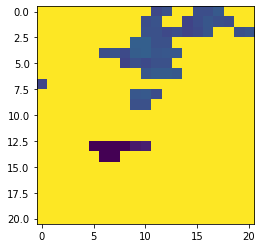

In [36]:
plt.imshow(dataset_sub_a[1000,0,:,:])

## Train feat download and processing

In [7]:
#grab date/cell_id combos
dates = {}

#go through all rows, grab nonnull dates
for i in range(train_feat.shape[0]):
    dates[train_feat.iloc[i,0]] =list(
        train_feat.iloc[i,1:][~train_feat.iloc[i,:].isnull()].index)#cell_id : [dates]    

In [8]:
train_feat = train_feat.rename({'Unnamed: 0': 'station_id'}, axis=1)
train_feat = train_feat.merge(metadata)

In [9]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in tqdm(dates.items()):
    row = train_feat[train_feat.station_id==cell]
    
    for date in date_list: 
        modis_tile = lat_lon_to_modis_tile(row.latitude.values[0], row.longitude.values[0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

  0%|          | 0/700 [00:00<?, ?it/s]

total squares: 144015


Load Terra images

In [10]:
#get coordinates into correct format
a= train_feat.set_index("station_id")
a= a[['latitude','longitude']]
centroids_feat = {}

for i in range(a.shape[0]):
    row = a.iloc[i,:]
    centroids_feat[row.name]= [row[1],row[0]]

del a

In [11]:
product = 'MOD10A1' # Terra -morning
# product = 'MCD43A4'

#initialize empty array
dataset_t = np.empty((counter, 7, 21, 21)) #(image, band, row, column)
    
# download dataset
cell_ids, dataset_t = images_downloader(tiles, centroids_feat, dataset_t, product,
                                        verbose = True)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_trainfeat_T.npy"
np.save(output_path,dataset_t)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_trainfeat.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

  0%|          | 0/1065 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MOD10A1/08/04/2013001/MOD10A1.A2013001.h08v04.006.2016134180715.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 22
Found 1 matching file(s):
MOD10A1/08/04/2013008/MOD10A1.A2013008.h08v04.006.2016134235739.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 44
Found 1 matching file(s):
MOD10A1/08/04/2013015/MOD10A1.A2013015.h08v04.006.2016134234828.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013015 CDEC:HMB
input shape:  (3283, 862) output shape (7, 

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013162 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 507
Found 1 matching file(s):
MOD10A1/08/04/2013169/MOD10A1.A2013169.h08v04.006.2016143114033.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013169 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 527
Found 1 matching file(s):
MOD10A1/08/04/2013176/MOD10A1.A2013176.h08v04.006.2016145063045.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 547
Found 1 matchi

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014119 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 997
Found 1 matching file(s):
MOD10A1/08/04/2014126/MOD10A1.A2014126.h08v04.006.2016170144515.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014126 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1018
Found 1 matching file(s):
MOD10A1/08/04/2014133/MOD10A1.A2014133.h08v04.006.2016170160349.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1038
Found 1 matc

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015069 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1478
Found 1 matching file(s):
MOD10A1/08/04/2015076/MOD10A1.A2015076.h08v04.006.2016173140321.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015076 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1499
Found 1 matching file(s):
MOD10A1/08/04/2015083/MOD10A1.A2015083.h08v04.006.2016174182401.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015083 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1520
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016019 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1963
Found 1 matching file(s):
MOD10A1/08/04/2016026/MOD10A1.A2016026.h08v04.006.2016028090734.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016026 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1985
Found 1 matching file(s):
MOD10A1/08/04/2016033/MOD10A1.A2016033.h08v04.006.2016036013703.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2007
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016180 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2409
Found 1 matching file(s):
MOD10A1/08/04/2016341/MOD10A1.A2016341.h08v04.006.2016343080326.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016341 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2432
Found 1 matching file(s):
MOD10A1/08/04/2016348/MOD10A1.A2016348.h08v04.006.2016350112247.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016348 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2455
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2923
Found 1 matching file(s):
MOD10A1/08/04/2017143/MOD10A1.A2017143.h08v04.006.2017145031639.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2945
Found 1 matching file(s):
MOD10A1/08/04/2017150/MOD10A1.A2017150.h08v04.006.2017152031055.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017150 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2967
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018086 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3451
Found 1 matching file(s):
MOD10A1/08/04/2018093/MOD10A1.A2018093.h08v04.006.2018095031130.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018093 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3474
Found 1 matching file(s):
MOD10A1/08/04/2018100/MOD10A1.A2018100.h08v04.006.2018102033140.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3497
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3982
Found 1 matching file(s):
MOD10A1/08/04/2019043/MOD10A1.A2019043.h08v04.006.2019045030132.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019043 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 4006
Found 1 matching file(s):
MOD10A1/08/04/2019050/MOD10A1.A2019050.h08v04.006.2019052041500.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019050 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 4030
Found 1 mat

Found 1 matching file(s):
MOD10A1/08/05/2013029/MOD10A1.A2013029.h08v05.006.2016134215005.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013029 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 5046
Found 1 matching file(s):
MOD10A1/08/05/2013036/MOD10A1.A2013036.h08v05.006.2016134202945.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013036 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 5176
Found 1 matching file(s):
MOD10A1/08/05/2013043/MOD10A1.A2013043.h08v05.006.2016137165951.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013043 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

Found 1 matching file(s):
MOD10A1/08/05/2013344/MOD10A1.A2013344.h08v05.006.2016162135227.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013344 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 7967
Found 1 matching file(s):
MOD10A1/08/05/2013351/MOD10A1.A2013351.h08v05.006.2016162113955.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 8098
Found 1 matching file(s):
MOD10A1/08/05/2013358/MOD10A1.A2013358.h08v05.006.2016162141757.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013358 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

Found 1 matching file(s):
MOD10A1/08/05/2014140/MOD10A1.A2014140.h08v05.006.2016170044819.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014140 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 10922
Found 1 matching file(s):
MOD10A1/08/05/2014147/MOD10A1.A2014147.h08v05.006.2016170041618.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014147 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 11048
Found 1 matching file(s):
MOD10A1/08/05/2014154/MOD10A1.A2014154.h08v05.006.2016170033136.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014154 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 2

Found 1 matching file(s):
MOD10A1/08/05/2015104/MOD10A1.A2015104.h08v05.006.2016175072219.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015104 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 14101
Found 1 matching file(s):
MOD10A1/08/05/2015111/MOD10A1.A2015111.h08v05.006.2016175080936.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015111 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 14230
Found 1 matching file(s):
MOD10A1/08/05/2015118/MOD10A1.A2015118.h08v05.006.2016175092607.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015118 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 2

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016047 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 16952
Found 0 matching file(s):
No file found: tile (8, 5) date 2016054
trying: 2016053
No file found: tile (8, 5) date 2016053
trying: 2016052
No file found: tile (8, 5) date 2016052
trying: 2016051
No file found: tile (8, 5) date 2016051
trying: 2016050
No file found: tile (8, 5) date 2016050
trying: 2016049
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016054 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 17075
Found 1 matching file(s):
MOD10A1/08/05/2016061/MOD10A1.A2016061.h08v05.006.2016103054636.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 19833
Found 1 matching file(s):
MOD10A1/08/05/2017003/MOD10A1.A2017003.h08v05.006.2017006135045.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017003 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 19965
Found 1 matching file(s):
MOD10A1/08/05/2017010/MOD10A1.A2017010.h08v05.006.2017012100741.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017010 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 20096
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017157 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 22733
Found 1 matching file(s):
MOD10A1/08/05/2017164/MOD10A1.A2017164.h08v05.006.2017166030123.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017164 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 22853
Found 1 matching file(s):
MOD10A1/08/05/2017171/MOD10A1.A2017171.h08v05.006.2017173030919.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 22973
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 25661
Found 1 matching file(s):
MOD10A1/08/05/2018114/MOD10A1.A2018114.h08v05.006.2018116033214.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018114 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 25787
Found 1 matching file(s):
MOD10A1/08/05/2018121/MOD10A1.A2018121.h08v05.006.2018123032241.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018121 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 25914
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019057 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 28958
Found 1 matching file(s):
MOD10A1/08/05/2019064/MOD10A1.A2019064.h08v05.006.2019066025943.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 29086
Found 1 matching file(s):
MOD10A1/08/05/2019071/MOD10A1.A2019071.h08v05.006.2019073033609.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 29214
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019127 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 31363
Found 1 matching file(s):
MOD10A1/08/04/2019134/MOD10A1.A2019134.h08v04.006.2019136030309.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 31385
Found 1 matching file(s):
MOD10A1/08/04/2019148/MOD10A1.A2019148.h08v04.006.2019150033521.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019148 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 31407
Found 1 

Found 1 matching file(s):
MOD10A1/09/04/2013050/MOD10A1.A2013050.h09v04.006.2016137170041.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, 

Found 1 matching file(s):
MOD10A1/09/04/2013092/MOD10A1.A2013092.h09v04.006.2016139053833.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, 

Found 1 matching file(s):
MOD10A1/09/04/2013351/MOD10A1.A2013351.h09v04.006.2016162134732.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 37222
Found 1 matching file(s):
MOD10A1/09/04/2014021/MOD10A1.A2014021.h09v04.006.2016167010259.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014021 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014021 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014021 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 38535
Found 1 matching file(s):
MOD10A1/09/04/2014056/MOD10A1.A2014056.h09v04.006.2016169084223.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014056 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014056 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014056 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2014091/MOD10A1.A2014091.h09v04.006.2016169054347.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2014133/MOD10A1.A2014133.h09v04.006.2016170160400.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2014168/MOD10A1.A2014168.h09v04.006.2016170220713.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014168 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014168 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014168 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 43811
Found 1 matching file(s):
MOD10A1/09/04/2014357/MOD10A1.A2014357.h09v04.006.2016180223854.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014357 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014357 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014357 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 45151
Found 1 matching file(s):
MOD10A1/09/04/2015027/MOD10A1.A2015027.h09v04.006.2016173062009.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015027 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015027 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015027 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 46490
Found 1 matching file(s):
MOD10A1/09/04/2015062/MOD10A1.A2015062.h09v04.006.2016173231711.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015062 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015062 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015062 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2015097/MOD10A1.A2015097.h09v04.006.2016174172316.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015097 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015097 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015097 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2015174/MOD10A1.A2015174.h09v04.006.2016175203906.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 50503
Found 1 matching file(s):
MOD10A1/09/04/2015363/MOD10A1.A2015363.h09v04.006.2016182180026.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 51843
Found 1 matching file(s):
MOD10A1/09/04/2016033/MOD10A1.A2016033.h09v04.006.2016036011955.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 53183
Found 1 matching file(s):
MOD10A1/09/04/2016068/MOD10A1.A2016068.h09v04.006.2016103171537.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016068 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016068 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016068 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2016103/MOD10A1.A2016103.h09v04.006.2016105122513.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016103 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016103 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016103 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 55863
Found 1 matching file(s):
MOD10A1/09/04/2016138/MOD10A1.A2016138.h09v04.006.2016140072457.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016138 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016138 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016138 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2016173/MOD10A1.A2016173.h09v04.006.2016175065824.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016173 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016173 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016173 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2016362/MOD10A1.A2016362.h09v04.006.2016364101237.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2017031/MOD10A1.A2017031.h09v04.006.2017033101506.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 61222
Found 1 matching file(s):
MOD10A1/09/04/2017073/MOD10A1.A2017073.h09v04.006.2017075085424.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017073 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017073 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017073 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 62562
Found 1 matching file(s):
MOD10A1/09/04/2017108/MOD10A1.A2017108.h09v04.006.2017110030612.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017108 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017108 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017108 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2017143/MOD10A1.A2017143.h09v04.006.2017145034121.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 65237
Found 1 matching file(s):
MOD10A1/09/04/2017178/MOD10A1.A2017178.h09v04.006.2017180031002.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017178 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017178 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017178 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 66573
Found 1 matching file(s):
MOD10A1/09/04/2018002/MOD10A1.A2018002.h09v04.006.2018004030811.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018002 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018002 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018002 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 67908
Found 1 matching file(s):
MOD10A1/09/04/2018037/MOD10A1.A2018037.h09v04.006.2018039031548.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018037 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018037 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018037 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 69243
Found 1 matching file(s):
MOD10A1/09/04/2018072/MOD10A1.A2018072.h09v04.006.2018074032751.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018072 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018072 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018072 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2018107/MOD10A1.A2018107.h09v04.006.2018109032300.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 71910
Found 1 matching file(s):
MOD10A1/09/04/2018142/MOD10A1.A2018142.h09v04.006.2018144033513.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018142 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018142 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018142 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2018177/MOD10A1.A2018177.h09v04.006.2018179032847.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018177 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018177 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018177 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 74594
Found 1 matching file(s):
MOD10A1/09/04/2019001/MOD10A1.A2019001.h09v04.006.2019003025410.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019001 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019001 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019001 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2019036/MOD10A1.A2019036.h09v04.006.2019038173048.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2019071/MOD10A1.A2019071.h09v04.006.2019073034021.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 78645
Found 1 matching file(s):
MOD10A1/09/04/2019113/MOD10A1.A2019113.h09v04.006.2019115032634.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019113 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019113 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019113 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MOD10A1/09/04/2019337/MOD10A1.A2019337.h09v04.006.2019339032546.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019337 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019337 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019337 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 81341
Found 1 matching file(s):
MOD10A1/09/04/2013001/MOD10A1.A2013001.h09v04.006.2016134180848.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds

Found 1 matching file(s):
MOD10A1/09/04/2013148/MOD10A1.A2013148.h09v04.006.2016142011959.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013148 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013148 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013148 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, 

Found 1 matching file(s):
MOD10A1/09/04/2015139/MOD10A1.A2015139.h09v04.006.2016174224251.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015139 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015139 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015139 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2019078/MOD10A1.A2019078.h09v04.006.2019080032710.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019078 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019078 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019078 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MOD10A1/09/04/2014105/MOD10A1.A2014105.h09v04.006.2016169234831.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014105 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014105 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014105 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017066 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017066 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017066 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017066 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MOD10A1/09/05/2017136/MOD10A1.A2017136.h09v05.006.2017138030617.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018065 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018065 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018065 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018065 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018170 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018170 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018170 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018170 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018359 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018359 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018359 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018359 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019099 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019099 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019099 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019099 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma


 122026
Found 1 matching file(s):
MOD10A1/10/04/2014126/MOD10A1.A2014126.h10v04.006.2016170152505.hdf

 122155
Found 1 matching file(s):
MOD10A1/10/04/2014133/MOD10A1.A2014133.h10v04.006.2016170160338.hdf

 122284
Found 1 matching file(s):
MOD10A1/10/04/2014140/MOD10A1.A2014140.h10v04.006.2016170045331.hdf

 122413
Found 1 matching file(s):
MOD10A1/10/04/2014147/MOD10A1.A2014147.h10v04.006.2016170050011.hdf

 122542
Found 1 matching file(s):
MOD10A1/10/04/2014154/MOD10A1.A2014154.h10v04.006.2016170041841.hdf

 122671
Found 1 matching file(s):
MOD10A1/10/04/2014161/MOD10A1.A2014161.h10v04.006.2016170065800.hdf

 122800
Found 1 matching file(s):
MOD10A1/10/04/2014168/MOD10A1.A2014168.h10v04.006.2016170204724.hdf

 122930
Found 1 matching file(s):
MOD10A1/10/04/2014175/MOD10A1.A2014175.h10v04.006.2016170201333.hdf

 123060
Found 1 matching file(s):
MOD10A1/10/04/2014336/MOD10A1.A2014336.h10v04.006.2016180002535.hdf

 123193
Found 1 matching file(s):
MOD10A1/10/04/2014343/MOD10A1.A2014343


 132408
Found 1 matching file(s):
MOD10A1/10/04/2017031/MOD10A1.A2017031.h10v04.006.2017033101501.hdf

 132541
Found 1 matching file(s):
MOD10A1/10/04/2017038/MOD10A1.A2017038.h10v04.006.2017040202342.hdf

 132675
Found 1 matching file(s):
MOD10A1/10/04/2017045/MOD10A1.A2017045.h10v04.006.2017047103819.hdf

 132809
Found 1 matching file(s):
MOD10A1/10/04/2017052/MOD10A1.A2017052.h10v04.006.2017054100808.hdf

 132943
Found 1 matching file(s):
MOD10A1/10/04/2017059/MOD10A1.A2017059.h10v04.006.2017061191146.hdf

 133077
Found 1 matching file(s):
MOD10A1/10/04/2017066/MOD10A1.A2017066.h10v04.006.2017068075725.hdf

 133211
Found 1 matching file(s):
MOD10A1/10/04/2017073/MOD10A1.A2017073.h10v04.006.2017075090228.hdf

 133345
Found 1 matching file(s):
MOD10A1/10/04/2017080/MOD10A1.A2017080.h10v04.006.2017082122421.hdf

 133479
Found 1 matching file(s):
MOD10A1/10/04/2017087/MOD10A1.A2017087.h10v04.006.2017089121034.hdf

 133613
Found 1 matching file(s):
MOD10A1/10/04/2017094/MOD10A1.A2017094


 143077
Found 1 matching file(s):
MOD10A1/10/04/2019169/MOD10A1.A2019169.h10v04.006.2019171035555.hdf

 143211
Found 1 matching file(s):
MOD10A1/10/04/2019176/MOD10A1.A2019176.h10v04.006.2019178031925.hdf

 143345
Found 1 matching file(s):
MOD10A1/10/04/2019337/MOD10A1.A2019337.h10v04.006.2019339043002.hdf

 143479
Found 1 matching file(s):
MOD10A1/10/04/2019344/MOD10A1.A2019344.h10v04.006.2019346032919.hdf

 143613
Found 1 matching file(s):
MOD10A1/10/04/2019351/MOD10A1.A2019351.h10v04.006.2019353033045.hdf

 143747
Found 1 matching file(s):
MOD10A1/10/04/2019358/MOD10A1.A2019358.h10v04.006.2019360024322.hdf

 143881
Found 1 matching file(s):
MOD10A1/10/04/2019365/MOD10A1.A2019365.h10v04.006.2020002214659.hdf


Load Aqua Images

In [12]:
product = 'MYD10A1'

#initialize empty array
dataset_a = np.empty((counter, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_a, dataset_a = images_downloader(tiles, centroids_feat, dataset_a, product,
                                        verbose = True)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_trainfeat_A.npy"
np.save(output_path,dataset_a)

assert cell_ids_a == cell_ids

  0%|          | 0/1065 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MYD10A1/08/04/2013001/MYD10A1.A2013001.h08v04.006.2016134181108.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 22
Found 1 matching file(s):
MYD10A1/08/04/2013008/MYD10A1.A2013008.h08v04.006.2016134232631.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 44
Found 1 matching file(s):
MYD10A1/08/04/2013015/MYD10A1.A2013015.h08v04.006.2016134215532.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013015 CDEC:HMB
input shape:  (3283, 862) output shape (7, 

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013162 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 507
Found 1 matching file(s):
MYD10A1/08/04/2013169/MYD10A1.A2013169.h08v04.006.2016143201825.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013169 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 527
Found 1 matching file(s):
MYD10A1/08/04/2013176/MYD10A1.A2013176.h08v04.006.2016145074116.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 547
Found 1 matchi

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014119 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 997
Found 1 matching file(s):
MYD10A1/08/04/2014126/MYD10A1.A2014126.h08v04.006.2016170151749.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014126 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1018
Found 1 matching file(s):
MYD10A1/08/04/2014133/MYD10A1.A2014133.h08v04.006.2016170180700.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1038
Found 1 matc

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015069 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1478
Found 1 matching file(s):
MYD10A1/08/04/2015076/MYD10A1.A2015076.h08v04.006.2016173155423.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015076 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1499
Found 1 matching file(s):
MYD10A1/08/04/2015083/MYD10A1.A2015083.h08v04.006.2016174163323.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015083 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1520
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016019 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1963
Found 1 matching file(s):
MYD10A1/08/04/2016026/MYD10A1.A2016026.h08v04.006.2016028074339.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016026 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 1985
Found 1 matching file(s):
MYD10A1/08/04/2016033/MYD10A1.A2016033.h08v04.006.2016035134747.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2007
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016180 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2409
Found 1 matching file(s):
MYD10A1/08/04/2016341/MYD10A1.A2016341.h08v04.006.2016343070118.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016341 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2432
Found 1 matching file(s):
MYD10A1/08/04/2016348/MYD10A1.A2016348.h08v04.006.2016351012854.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016348 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2455
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2923
Found 1 matching file(s):
MYD10A1/08/04/2017143/MYD10A1.A2017143.h08v04.006.2017145031438.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2945
Found 1 matching file(s):
MYD10A1/08/04/2017150/MYD10A1.A2017150.h08v04.006.2017152030429.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017150 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 2967
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018086 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3451
Found 1 matching file(s):
MYD10A1/08/04/2018093/MYD10A1.A2018093.h08v04.006.2018095031148.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018093 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3474
Found 1 matching file(s):
MYD10A1/08/04/2018100/MYD10A1.A2018100.h08v04.006.2018102033153.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3497
Found 1 mat

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 3982
Found 1 matching file(s):
MYD10A1/08/04/2019043/MYD10A1.A2019043.h08v04.006.2019045034604.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019043 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 4006
Found 1 matching file(s):
MYD10A1/08/04/2019050/MYD10A1.A2019050.h08v04.006.2019052041156.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019050 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 4030
Found 1 mat

Found 1 matching file(s):
MYD10A1/08/05/2013029/MYD10A1.A2013029.h08v05.006.2016134215042.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013029 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 5046
Found 1 matching file(s):
MYD10A1/08/05/2013036/MYD10A1.A2013036.h08v05.006.2016134202934.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013036 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 5176
Found 1 matching file(s):
MYD10A1/08/05/2013043/MYD10A1.A2013043.h08v05.006.2016137172206.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013043 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

Found 1 matching file(s):
MYD10A1/08/05/2013344/MYD10A1.A2013344.h08v05.006.2016162145638.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013344 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 7967
Found 1 matching file(s):
MYD10A1/08/05/2013351/MYD10A1.A2013351.h08v05.006.2016162134519.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 8098
Found 1 matching file(s):
MYD10A1/08/05/2013358/MYD10A1.A2013358.h08v05.006.2016162150529.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013358 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014140 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 10922
Found 1 matching file(s):
MYD10A1/08/05/2014147/MYD10A1.A2014147.h08v05.006.2016170041206.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014147 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 11048
Found 1 matching file(s):
MYD10A1/08/05/2014154/MYD10A1.A2014154.h08v05.006.2016170043411.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014154 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 11170
Found 1 matching fil

Found 1 matching file(s):
MYD10A1/08/05/2015104/MYD10A1.A2015104.h08v05.006.2016175103748.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015104 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 14101
Found 1 matching file(s):
MYD10A1/08/05/2015111/MYD10A1.A2015111.h08v05.006.2016175113353.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015111 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 14230
Found 1 matching file(s):
MYD10A1/08/05/2015118/MYD10A1.A2015118.h08v05.006.2016175110327.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015118 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 2

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016047 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 16952
Found 1 matching file(s):
MYD10A1/08/05/2016054/MYD10A1.A2016054.h08v05.006.2016056081053.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016054 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 17075
Found 1 matching file(s):
MYD10A1/08/05/2016061/MYD10A1.A2016061.h08v05.006.2016065015910.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016061 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 17202
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 19833
Found 1 matching file(s):
MYD10A1/08/05/2017003/MYD10A1.A2017003.h08v05.006.2017005093509.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017003 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 19965
Found 1 matching file(s):
MYD10A1/08/05/2017010/MYD10A1.A2017010.h08v05.006.2017012100453.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017010 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 20096
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017157 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 22733
Found 1 matching file(s):
MYD10A1/08/05/2017164/MYD10A1.A2017164.h08v05.006.2017166032218.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017164 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 22853
Found 1 matching file(s):
MYD10A1/08/05/2017171/MYD10A1.A2017171.h08v05.006.2017173032330.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 22973
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 25661
Found 1 matching file(s):
MYD10A1/08/05/2018114/MYD10A1.A2018114.h08v05.006.2018116032906.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018114 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 25787
Found 1 matching file(s):
MYD10A1/08/05/2018121/MYD10A1.A2018121.h08v05.006.2018123032251.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018121 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 25914
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019057 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 28958
Found 1 matching file(s):
MYD10A1/08/05/2019064/MYD10A1.A2019064.h08v05.006.2019066023411.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 29086
Found 1 matching file(s):
MYD10A1/08/05/2019071/MYD10A1.A2019071.h08v05.006.2019073032045.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 29214
Found 1 matching fil

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019127 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 31363
Found 1 matching file(s):
MYD10A1/08/04/2019134/MYD10A1.A2019134.h08v04.006.2019136190747.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 31385
Found 1 matching file(s):
MYD10A1/08/04/2019148/MYD10A1.A2019148.h08v04.006.2019150033848.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019148 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 31407
Found 1 


 32787
Found 1 matching file(s):
MYD10A1/09/04/2013050/MYD10A1.A2013050.h09v04.006.2016137161348.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds

Found 1 matching file(s):
MYD10A1/09/04/2013092/MYD10A1.A2013092.h09v04.006.2016139062200.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, 

Found 1 matching file(s):
MYD10A1/09/04/2013351/MYD10A1.A2013351.h09v04.006.2016162134317.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013351 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 37222
Found 1 matching file(s):
MYD10A1/09/04/2014021/MYD10A1.A2014021.h09v04.006.2016167013129.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014021 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014021 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014021 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MYD10A1/09/04/2014056/MYD10A1.A2014056.h09v04.006.2016169102925.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014056 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014056 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014056 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 39850
Found 1 matching file(s):
MYD10A1/09/04/2014091/MYD10A1.A2014091.h09v04.006.2016169045252.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 41165
Found 1 matching file(s):
MYD10A1/09/04/2014133/MYD10A1.A2014133.h09v04.006.2016170180658.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 42480
Found 1 matching file(s):
MYD10A1/09/04/2014168/MYD10A1.A2014168.h09v04.006.2016170221629.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014168 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014168 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014168 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 43811
Found 1 matching file(s):
MYD10A1/09/04/2014357/MYD10A1.A2014357.h09v04.006.2016179190239.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014357 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014357 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014357 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MYD10A1/09/04/2015027/MYD10A1.A2015027.h09v04.006.2016173080701.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015027 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015027 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015027 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2015062/MYD10A1.A2015062.h09v04.006.2016174030225.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015062 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015062 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015062 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2015097/MYD10A1.A2015097.h09v04.006.2016174170702.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015097 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015097 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015097 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2015174/MYD10A1.A2015174.h09v04.006.2016175193840.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2015363/MYD10A1.A2015363.h09v04.006.2016182141934.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2016033/MYD10A1.A2016033.h09v04.006.2016035134731.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016033 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2016068/MYD10A1.A2016068.h09v04.006.2016070070522.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016068 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016068 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016068 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 54523
Found 1 matching file(s):
MYD10A1/09/04/2016103/MYD10A1.A2016103.h09v04.006.2016105122229.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016103 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016103 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016103 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MYD10A1/09/04/2016138/MYD10A1.A2016138.h09v04.006.2016140063006.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016138 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016138 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016138 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2016173/MYD10A1.A2016173.h09v04.006.2016180000625.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016173 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016173 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016173 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2016362/MYD10A1.A2016362.h09v04.006.2016364081243.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2017031/MYD10A1.A2017031.h09v04.006.2017040040739.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2017073/MYD10A1.A2017073.h09v04.006.2017075075644.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017073 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017073 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017073 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 62562
Found 1 matching file(s):
MYD10A1/09/04/2017108/MYD10A1.A2017108.h09v04.006.2017110042441.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017108 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017108 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017108 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MYD10A1/09/04/2017143/MYD10A1.A2017143.h09v04.006.2017145032913.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017143 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2017178/MYD10A1.A2017178.h09v04.006.2017180024403.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017178 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017178 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017178 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2018002/MYD10A1.A2018002.h09v04.006.2018004030651.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018002 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018002 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018002 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 67908
Found 1 matching file(s):
MYD10A1/09/04/2018037/MYD10A1.A2018037.h09v04.006.2018039031658.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018037 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018037 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018037 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 69243
Found 1 matching file(s):
MYD10A1/09/04/2018072/MYD10A1.A2018072.h09v04.006.2018074032815.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018072 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018072 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018072 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 70578
Found 1 matching file(s):
MYD10A1/09/04/2018107/MYD10A1.A2018107.h09v04.006.2018109031943.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018107 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 71910
Found 1 matching file(s):
MYD10A1/09/04/2018142/MYD10A1.A2018142.h09v04.006.2018144033314.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018142 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018142 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018142 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MYD10A1/09/04/2018177/MYD10A1.A2018177.h09v04.006.2018179032726.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018177 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018177 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018177 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2019001/MYD10A1.A2019001.h09v04.006.2019003030727.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019001 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019001 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019001 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2019036/MYD10A1.A2019036.h09v04.006.2019038032137.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019036 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2019071/MYD10A1.A2019071.h09v04.006.2019073032647.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019071 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 78645
Found 1 matching file(s):
MYD10A1/09/04/2019113/MYD10A1.A2019113.h09v04.006.2019115031834.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019113 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019113 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019113 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

Found 1 matching file(s):
MYD10A1/09/04/2019337/MYD10A1.A2019337.h09v04.006.2019339034307.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019337 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019337 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019337 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,

Found 1 matching file(s):
MYD10A1/09/04/2013001/MYD10A1.A2013001.h09v04.006.2016134181107.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013001 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, 

Found 1 matching file(s):
MYD10A1/09/04/2013148/MYD10A1.A2013148.h09v04.006.2016142021130.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013148 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013148 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013148 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, 

Found 1 matching file(s):
MYD10A1/09/04/2015139/MYD10A1.A2015139.h09v04.006.2016174234049.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015139 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015139 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015139 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error,


 85781
Found 1 matching file(s):
MYD10A1/09/04/2019078/MYD10A1.A2019078.h09v04.006.2019080031817.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019078 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019078 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019078 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound


 87121
Found 1 matching file(s):
MYD10A1/09/04/2014105/MYD10A1.A2014105.h09v04.006.2016170005117.hdf
could not broadcast input array from shape (7,16,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014105 SNOTEL:1061_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 16)
max/min 3041 923 3020 902
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,14,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014105 SNOTEL:1187_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 14)
max/min 3157 925 3136 904
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014105 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bound

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013008 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013050 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013092 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013134 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2013176 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014007 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014049 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

Found 1 matching file(s):
MYD10A1/09/05/2014091/MYD10A1.A2014091.h09v05.006.2016169052231.hdf
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014091 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 

Found 1 matching file(s):
MYD10A1/09/05/2014133/MYD10A1.A2014133.h09v05.006.2016170145859.hdf
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014133 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2014175 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015006 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015048 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015090 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015132 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

Found 1 matching file(s):
MYD10A1/09/05/2015174/MYD10A1.A2015174.h09v05.006.2016175193840.hdf
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015174 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2015363 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016040 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016082 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016124 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
max/min 1298 11 1277 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016166 SNOTEL:844_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
m

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2016362 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MYD10A1/09/05/2017031/MYD10A1.A2017031.h09v05.006.2017040040339.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017031 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MYD10A1/09/05/2017066/MYD10A1.A2017066.h09v05.006.2017070021015.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017066 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017066 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017066 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017101 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

MYD10A1/09/05/2017136/MYD10A1.A2017136.h09v05.006.2017138030334.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017136 SNOTE

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017171 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2017360 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018030 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MYD10A1/09/05/2018065/MYD10A1.A2018065.h09v05.006.2018067025414.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018065 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018065 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018065 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018100 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018135 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MYD10A1/09/05/2018170/MYD10A1.A2018170.h09v05.006.2018172031950.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018170 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018170 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018170 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MYD10A1/09/05/2018359/MYD10A1.A2018359.h09v05.006.2018361032720.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018359 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018359 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2018359 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019029 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MYD10A1/09/05/2019064/MYD10A1.A2019064.h09v05.006.2019066023236.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019064 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MYD10A1/09/05/2019099/MYD10A1.A2019099.h09v05.006.2019101023147.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019099 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019099 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019099 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019134 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019169 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2019358 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma


 122026
Found 1 matching file(s):
MYD10A1/10/04/2014126/MYD10A1.A2014126.h10v04.006.2016170151709.hdf

 122155
Found 1 matching file(s):
MYD10A1/10/04/2014133/MYD10A1.A2014133.h10v04.006.2016170181939.hdf

 122284
Found 1 matching file(s):
MYD10A1/10/04/2014140/MYD10A1.A2014140.h10v04.006.2016170061002.hdf

 122413
Found 1 matching file(s):
MYD10A1/10/04/2014147/MYD10A1.A2014147.h10v04.006.2016170041534.hdf

 122542
Found 1 matching file(s):
MYD10A1/10/04/2014154/MYD10A1.A2014154.h10v04.006.2016170042949.hdf

 122671
Found 1 matching file(s):
MYD10A1/10/04/2014161/MYD10A1.A2014161.h10v04.006.2016170073241.hdf

 122800
Found 1 matching file(s):
MYD10A1/10/04/2014168/MYD10A1.A2014168.h10v04.006.2016170224951.hdf

 122930
Found 1 matching file(s):
MYD10A1/10/04/2014175/MYD10A1.A2014175.h10v04.006.2016170200915.hdf

 123060
Found 1 matching file(s):
MYD10A1/10/04/2014336/MYD10A1.A2014336.h10v04.006.2016177062428.hdf

 123193
Found 1 matching file(s):
MYD10A1/10/04/2014343/MYD10A1.A2014343


 132675
Found 1 matching file(s):
MYD10A1/10/04/2017045/MYD10A1.A2017045.h10v04.006.2017047062858.hdf

 132809
Found 1 matching file(s):
MYD10A1/10/04/2017052/MYD10A1.A2017052.h10v04.006.2017054101414.hdf

 132943
Found 1 matching file(s):
MYD10A1/10/04/2017059/MYD10A1.A2017059.h10v04.006.2017061203501.hdf

 133077
Found 1 matching file(s):
MYD10A1/10/04/2017066/MYD10A1.A2017066.h10v04.006.2017070020935.hdf

 133211
Found 1 matching file(s):
MYD10A1/10/04/2017073/MYD10A1.A2017073.h10v04.006.2017075075734.hdf

 133345
Found 1 matching file(s):
MYD10A1/10/04/2017080/MYD10A1.A2017080.h10v04.006.2017082120206.hdf

 133479
Found 1 matching file(s):
MYD10A1/10/04/2017087/MYD10A1.A2017087.h10v04.006.2017089111319.hdf

 133613
Found 1 matching file(s):
MYD10A1/10/04/2017094/MYD10A1.A2017094.h10v04.006.2017096062324.hdf

 133747
Found 1 matching file(s):
MYD10A1/10/04/2017101/MYD10A1.A2017101.h10v04.006.2017103032100.hdf

 133881
Found 1 matching file(s):
MYD10A1/10/04/2017108/MYD10A1.A2017108


 143345
Found 1 matching file(s):
MYD10A1/10/04/2019337/MYD10A1.A2019337.h10v04.006.2019339033129.hdf

 143479
Found 1 matching file(s):
MYD10A1/10/04/2019344/MYD10A1.A2019344.h10v04.006.2019346040051.hdf

 143613
Found 1 matching file(s):
MYD10A1/10/04/2019351/MYD10A1.A2019351.h10v04.006.2019353040530.hdf

 143747
Found 1 matching file(s):
MYD10A1/10/04/2019358/MYD10A1.A2019358.h10v04.006.2019360181339.hdf

 143881
Found 1 matching file(s):
MYD10A1/10/04/2019365/MYD10A1.A2019365.h10v04.006.2020002225109.hdf


## Load Test_features data

In [13]:
#grab date/cell_id combos
dates = {}

#go through all rows, grab nonnull dates
for i in range(test.shape[0]):
    dates[test.iloc[i,0]] =list(
        test.iloc[i,1:][~test.iloc[i,:].isnull()].index)#cell_id : [dates]    

In [14]:
test = test.rename({'Unnamed: 0': 'station_id'}, axis=1)
test = test.merge(metadata)

In [15]:
# create dictionary tiles (date, lat, lon) : [cell_ids]
counter = 0 
tiles = defaultdict(list)
for cell, date_list in tqdm(dates.items()):
    row = test[test.station_id==cell]
    
    for date in date_list: 
        modis_tile = lat_lon_to_modis_tile(row.latitude.values[0], row.longitude.values[0])
        tiles[(datetime.fromisoformat(date),) + modis_tile].append(cell)
        counter += 1
print("total squares:", counter)    

  0%|          | 0/700 [00:00<?, ?it/s]

total squares: 38628


In [16]:
#get coordinates into correct format
a= test.set_index("station_id")
a= a[['latitude','longitude']]
centroids_feat = {}

for i in range(a.shape[0]):
    row = a.iloc[i,:]
    centroids_feat[row.name]= [row[1],row[0]]

del a

Load Terra images

In [17]:
product = 'MOD10A1' # Terra -morning
# product = 'MCD43A4'

#initialize empty array
dataset_t = np.empty((counter, 7, 21, 21)) #(image, band, row, column)
    
# download dataset
cell_ids, dataset_t = images_downloader(tiles, centroids_feat, dataset_t, product,
                                        verbose = True)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_testfeat_T.npy"
np.save(output_path,dataset_t)

path_ids = "C:/Users/Matt/Dropbox/SnowComp/cell_snow_ids_testfeat.pkl"
with open(path_ids, 'wb') as handle:
    pickle.dump(cell_ids, handle)

  0%|          | 0/285 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MOD10A1/08/04/2020007/MOD10A1.A2020007.h08v04.006.2020009031705.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 22
Found 1 matching file(s):
MOD10A1/08/04/2020014/MOD10A1.A2020014.h08v04.006.2020016204442.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020014 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 44
Found 1 matching file(s):
MOD10A1/08/04/2020021/MOD10A1.A2020021.h08v04.006.2020023032240.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020021 CDEC:HMB
input shape:  (3283, 862) output shape (7, 

Found 1 matching file(s):
MOD10A1/08/04/2021019/MOD10A1.A2021019.h08v04.006.2021021030345.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021019 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 554
Found 1 matching file(s):
MOD10A1/08/04/2021026/MOD10A1.A2021026.h08v04.006.2021028033052.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 578
Found 1 matching file(s):
MOD10A1/08/04/2021033/MOD10A1.A2021033.h08v04.006.2021035034001.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021033 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21

Found 1 matching file(s):
MOD10A1/08/05/2020070/MOD10A1.A2020070.h08v05.006.2020072032358.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 2147
Found 1 matching file(s):
MOD10A1/08/05/2020077/MOD10A1.A2020077.h08v05.006.2020079031942.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 2274
Found 1 matching file(s):
MOD10A1/08/05/2020084/MOD10A1.A2020084.h08v05.006.2020086030055.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020084 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

Found 1 matching file(s):
MOD10A1/08/05/2021012/MOD10A1.A2021012.h08v05.006.2021014025617.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021012 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 4985
Found 1 matching file(s):
MOD10A1/08/05/2021019/MOD10A1.A2021019.h08v05.006.2021021030115.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021019 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 5113
Found 1 matching file(s):
MOD10A1/08/05/2021026/MOD10A1.A2021026.h08v05.006.2021028032538.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

Found 1 matching file(s):
MOD10A1/08/05/2021173/MOD10A1.A2021173.h08v05.006.2021175032942.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 7759
Found 1 matching file(s):
MOD10A1/08/05/2021180/MOD10A1.A2021180.h08v05.006.2021182205825.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021180 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 7867
Found 1 matching file(s):
MOD10A1/08/04/2020119/MOD10A1.A2020119.h08v04.006.2020121032143.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020119 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)


could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

Found 1 matching file(s):
MOD10A1/09/05/2020035/MOD10A1.A2020035.h09v05.006.2020037024333.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020035 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020035 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020035 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MOD10A1/09/05/2020105/MOD10A1.A2020105.h09v05.006.2020107024711.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020105 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020105 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020105 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MOD10A1/09/05/2020140/MOD10A1.A2020140.h09v05.006.2020142043514.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MOD10A1/09/05/2020175/MOD10A1.A2020175.h09v05.006.2020177033256.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020175 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020175 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020175 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MOD10A1/09/05/2020357/MOD10A1.A2020357.h09v05.006.2020359030309.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MOD10A1/09/05/2021061/MOD10A1.A2021061.h09v05.006.2021063033725.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MOD10A1/09/05/2021096/MOD10A1.A2021096.h09v05.006.2021098032215.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021096 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021096 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021096 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MOD10A1/09/05/2021131/MOD10A1.A2021131.h09v05.006.2021133045343.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021131 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021131 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021131 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

Found 1 matching file(s):
MOD10A1/09/05/2021166/MOD10A1.A2021166.h09v05.006.2021168031359.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021166 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021166 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021166 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f


 35120
Found 1 matching file(s):
MOD10A1/10/04/2021005/MOD10A1.A2021005.h10v04.006.2021008182346.hdf

 35255
Found 1 matching file(s):
MOD10A1/10/04/2021012/MOD10A1.A2021012.h10v04.006.2021014025120.hdf

 35390
Found 1 matching file(s):
MOD10A1/10/04/2021019/MOD10A1.A2021019.h10v04.006.2021021030421.hdf

 35525
Found 1 matching file(s):
MOD10A1/10/04/2021026/MOD10A1.A2021026.h10v04.006.2021028033528.hdf

 35660
Found 1 matching file(s):
MOD10A1/10/04/2021033/MOD10A1.A2021033.h10v04.006.2021035033941.hdf

 35795
Found 1 matching file(s):
MOD10A1/10/04/2021040/MOD10A1.A2021040.h10v04.006.2021042032907.hdf

 35930
Found 1 matching file(s):
MOD10A1/10/04/2021047/MOD10A1.A2021047.h10v04.006.2021049040855.hdf

 36065
Found 1 matching file(s):
MOD10A1/10/04/2021054/MOD10A1.A2021054.h10v04.006.2021056034635.hdf

 36200
Found 1 matching file(s):
MOD10A1/10/04/2021061/MOD10A1.A2021061.h10v04.006.2021063032605.hdf

 36335
Found 1 matching file(s):
MOD10A1/10/04/2021068/MOD10A1.A2021068.h10v04.00

Load Aqua Data

In [18]:
product = 'MYD10A1'

#initialize empty array
dataset_a = np.empty((counter, 7, 21, 21)) #(image, band, row, column)

# download dataset
cell_ids_a, dataset_a = images_downloader(tiles, centroids_feat, dataset_a, product,
                                        verbose = True)
    
#####save output#####
output_path = "C:/Users/Matt/Dropbox/SnowComp/ModisSnowImages_trainfeat_A.npy"
np.save(output_path,dataset_a)

assert cell_ids_a == cell_ids

  0%|          | 0/285 [00:00<?, ?it/s]


 0
Found 1 matching file(s):
MYD10A1/08/04/2020007/MYD10A1.A2020007.h08v04.006.2020009032528.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 22
Found 1 matching file(s):
MYD10A1/08/04/2020014/MYD10A1.A2020014.h08v04.006.2020016023029.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020014 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 44
Found 1 matching file(s):
MYD10A1/08/04/2020021/MYD10A1.A2020021.h08v04.006.2020023034255.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020021 CDEC:HMB
input shape:  (3283, 862) output shape (7, 

Found 1 matching file(s):
MYD10A1/08/04/2021019/MYD10A1.A2021019.h08v04.006.2021021030458.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021019 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 554
Found 1 matching file(s):
MYD10A1/08/04/2021026/MYD10A1.A2021026.h08v04.006.2021028032307.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 578
Found 1 matching file(s):
MYD10A1/08/04/2021033/MYD10A1.A2021033.h08v04.006.2021035035032.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021033 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21

Found 1 matching file(s):
MYD10A1/08/05/2020070/MYD10A1.A2020070.h08v05.006.2020072033449.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 2147
Found 1 matching file(s):
MYD10A1/08/05/2020077/MYD10A1.A2020077.h08v05.006.2020079034514.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 2274
Found 1 matching file(s):
MYD10A1/08/05/2020084/MYD10A1.A2020084.h08v05.006.2020086033242.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020084 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

Found 1 matching file(s):
MYD10A1/08/05/2021012/MYD10A1.A2021012.h08v05.006.2021014030132.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021012 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 4985
Found 1 matching file(s):
MYD10A1/08/05/2021019/MYD10A1.A2021019.h08v05.006.2021021030937.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021019 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 5113
Found 1 matching file(s):
MYD10A1/08/05/2021026/MYD10A1.A2021026.h08v05.006.2021028031900.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 7759
Found 1 matching file(s):
MYD10A1/08/05/2021180/MYD10A1.A2021180.h08v05.006.2021182160028.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021180 CDEC:GRZ
input shape:  (3177, 1194) output shape (7, 21, 20)
max/min 1192 20 1171 0
off up
updated simage_shape (7, 21, 21)

 7867
Found 1 matching file(s):
MYD10A1/08/04/2020119/MYD10A1.A2020119.h08v04.006.2020121031903.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020119 CDEC:HMB
input shape:  (3283, 862) output shape (7, 21, 20)
max/min 2959 863 2938 842
off down
updated simage_shape (7, 21, 21)

 7888
Found 1 matching fi

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020007 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020042 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020077 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020112 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021103 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021138 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020161 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

could not broadcast input array from shape (7,17,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:607_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 17)
max/min 3073 922 3052 901
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:663_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 13)
max/min 3176 926 3155 905
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:717_CO_SNTL
input shape:  (3268, 918) output shape (7, 21, 20)
max/min 3015 919 2994 898
off down
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,13,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021173 SNOTEL:838_CO_SNTL
input shape:  (3268, 918) output shape 

Found 1 matching file(s):
MYD10A1/09/05/2020035/MYD10A1.A2020035.h09v05.006.2020038222531.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020035 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020035 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020035 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020070 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020105 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020105 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020105 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020105 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020140 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020175 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020175 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020175 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020175 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

MYD10A1/09/05/2020357/MYD10A1.A2020357.h09v05.006.2020359031411.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2020357 SNOTE

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021026 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

Found 1 matching file(s):
MYD10A1/09/05/2021061/MYD10A1.A2021061.h09v05.006.2021063043628.hdf
could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021061 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 f

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021096 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021096 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021096 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021096 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021131 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021131 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021131 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021131 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma

could not broadcast input array from shape (7,20,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021166 SNOTEL:1280_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 20)
max/min 735 20 714 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,18,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021166 SNOTEL:564_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 18)
max/min 1504 18 1483 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,19,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021166 SNOTEL:686_UT_SNTL
input shape:  (3153, 1256) output shape (7, 21, 19)
max/min 746 19 725 0
off up
updated simage_shape (7, 21, 21)
could not broadcast input array from shape (7,11,21) into shape (7,21,21)
Out of bounds error, padding with 0 for day/grid: 2021166 SNOTEL:827_CO_SNTL
input shape:  (3153, 1256) output shape (7, 21, 11)
ma


 35255
Found 1 matching file(s):
MYD10A1/10/04/2021012/MYD10A1.A2021012.h10v04.006.2021014031549.hdf

 35390
Found 1 matching file(s):
MYD10A1/10/04/2021019/MYD10A1.A2021019.h10v04.006.2021021030528.hdf

 35525
Found 1 matching file(s):
MYD10A1/10/04/2021026/MYD10A1.A2021026.h10v04.006.2021028031900.hdf

 35660
Found 1 matching file(s):
MYD10A1/10/04/2021033/MYD10A1.A2021033.h10v04.006.2021035035354.hdf

 35795
Found 1 matching file(s):
MYD10A1/10/04/2021040/MYD10A1.A2021040.h10v04.006.2021042045757.hdf

 35930
Found 1 matching file(s):
MYD10A1/10/04/2021047/MYD10A1.A2021047.h10v04.006.2021049032906.hdf

 36065
Found 1 matching file(s):
MYD10A1/10/04/2021054/MYD10A1.A2021054.h10v04.006.2021056035307.hdf

 36200
Found 1 matching file(s):
MYD10A1/10/04/2021061/MYD10A1.A2021061.h10v04.006.2021063043614.hdf

 36335
Found 1 matching file(s):
MYD10A1/10/04/2021068/MYD10A1.A2021068.h10v04.006.2021070042215.hdf

 36470
Found 1 matching file(s):
MYD10A1/10/04/2021075/MYD10A1.A2021075.h10v04.00

### Sanity Checks

In [132]:
# check how many filled with missing or empty
def data_quality_checker(dataset):
    which_idx = np.all(dataset[:,0,:,:]>100, axis = (1,2))
    bad_images = dataset[np.all(dataset[:,0,:,:]>100, axis = (1,2))] 
    print("all missing:", np.sum(np.all(dataset[:,0,:,:]>100, axis = (1,2))),
         "of:", dataset.shape[0])
    
    
    return bad_images, which_idx

def random_bad_plot(bad_images):
    idx = random.randrange(bad_images.shape[0])
    plt.imshow(bad_images[idx,0,:,:])
    print(idx)
    
bad_images, which_idx_a = data_quality_checker(dataset_a)
bad_images, which_idx_t = data_quality_checker(dataset_t)

print("overlapping:",  np.sum(which_idx_a & which_idx_t))

all missing: 8432 of: 38628
all missing: 7477 of: 38628
overlapping: 5005


6088


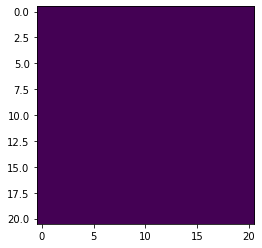

In [125]:
random_bad_plot(bad_images)